# Convolutional Deep Belief Network on CIFAR-10 dataset

## Introduction

In this notebook, I will explore the use of both Deep Belief Networks (DBN), Convolutional Deep Belief Networks (CDBN) and mixed networks on the task of image classification for coloured natural images.

DBNs are formed by stacking Restricted Boltzmann Machines (RBM) which have fully connected layers, while CDBNs are formed by stacking convolutional RBMs. The convolution results in more scalable models due to the reduction in parameters, however the fully connected layers capture more information, by exploring multiple architectures I hope to investigate which model can provide the best performance.

The paper which inspired this work is [Krizhevsky A. 2010 Convolutional Deep Belief Networks on CIFAR-10](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

In [1]:
def get_cdbn_library():
  files = ["CDBN.py", "CRBM.py", "DATA_HANDLER.py"]
  repository_url = "https://raw.githubusercontent.com/Chromainium/Convolutional_Deep_Belief_Network/master/src/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_cdbn_library()

import CRBM as crbm
import CDBN as cdbn
import DATA_HANDLER as data_handler

--2024-06-23 15:29:09--  https://raw.githubusercontent.com/Chromainium/Convolutional_Deep_Belief_Network/master/src/CDBN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37441 (37K) [text/plain]
Saving to: ‘CDBN.py’

CDBN.py             100%[===================>]  36.56K  --.-KB/s    in 0.03s   

2024-06-23 15:29:10 (1.02 MB/s) - ‘CDBN.py’ saved [37441/37441]

--2024-06-23 15:29:10--  https://raw.githubusercontent.com/Chromainium/Convolutional_Deep_Belief_Network/master/src/CRBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

Import all libraries that will be used in the notebook

In [2]:
import tensorflow.compat.v1 as tf1
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.utils import to_categorical
tf1.disable_eager_execution()

import random
import numpy as np
import math
import matplotlib.pyplot as plt

## Dataset

For this notebook 3 datasets were used. CIFAR-10, STL-10 and ImageNet. CIFAR-10 is a labelled subset of the [80 million tiny images](http://groups.csail.mit.edu/vision/TinyImages/) dataset. The paper which inspired this project used 1.6 million of these for pretraining before fine-tuning on the CIFAR-10 dataset. I would have liked to follow this procedure however the 80 million tiny images dataset was withdrawn due to offensive content. Thus for pre-training I searched for a different dataset.

The STL-10 dataset is taken from labelled examples on ImageNet. Since STL-10 was inspired py CIFAR-10, some of the categories are the same and It is my hope that the distribution of the images are similar enough so that the model can be pretrained on those examples.

ImageNET is extremely large 14 million images total and using a random subset of these, the hope is that the is sufficient variety in images that the model learns many useful features.

*   **CIFAR-10** : The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 completely mutually exclusive balanced classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'), with 6000 images per class. There are 50000 training images and 10000 test images.
*   **STL-10** : The STL-10 dataset consists of both labelled and unlabelled 96x96 color images. There are 5000 training images, and 8000 test images evenly distributed among the classes (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck). There is also 100000 unlabeled images for unsupervised learning. The unlabelled examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
*   **ImageNET** : The ImageNET dataset available in Tensorflow consists of 12 million images, due to usage limits in the Jupyter Notebook provided by CoLab only a subset 300000 images were used fot this project. This subset was chosen at random



## Method

*Datasets*

To evaluate the various models, various combinations of the different datasets were used.
1.   **Data Combo 1** : STL-10 100000 unlabelled examples for pre-training (unsupervised learning); CIFAR-10 for fine-tuning (supervised learning)
2.   **Data Combo 2** : ImageNET 300000 examples for pre-training (unsupervised learning); CIFAR-10 for fine-tuning (supervised learning)


*Models*

Various models were tested consisting of combinations of convolutional (conv) and fully connected (fc) layers

1.   **Model 1** : RBM with 2 fc layers
2.   **Model 2** : CRBM with 2 conv layers
3.   **Model 3** : CRBM with 1 conv, 1 fc layer
4.   **Model 4** : CRBM with 1 conv, 1 global and 1 fc layer

The results of a few other trials are not reported here. Namely **Model 5**, a CRBM with 3 conv layers, had a significant deterioration in performance compared to the model with only 2 conv layers. And also, **Model 6** which had 2 conv layers a global layer and a fully connected layer. Here again the additional layers resulted in worsening performance.

In the case of **Model 3** even though many different values for the hyperparameters were tried, the reconstruction error consistently remained at NaN which resulted in an accuracy of 10%.




## Overview of Results

% Accuracy on the Training Set

Models | Data | Combo
--- | --- | ---
 | STL+CIF | IMNET+CIF |
1. 2FC | 20.62 | 18.06
2. 2Conv | 47.35 | 45.99
3. 1Conv1FC | 10.00 | 10.00
4. 1Conv1G1FC | 52.95 | 51.93


% Accuracy on the Test Set

Models | Data | Combo
--- | --- | ---
| STL+CIF | IMNET+CIF |
1. 2FC | 21.01 | 18.03
2. 2Conv | 42.01 | 40.66
3. 1Conv1FC | 10.00 | 10.00
4. 1Conv1G1FC | 48.33 | 48.26


In the end, adding the additional global layer did not improve the model performance to a significant degree. Due to some randomness in the initialization on some trials the best performing model only had two convolutional layers and on other trials the best model had a global layer.




## Loading and Preparing the Data

### Utility Functions

In [6]:
def normalize_images(images, type='scale'):
  if type == 'scale':
    # scale the pixels values in [0,1]
    normalized_images = (images/255).reshape((images.shape[0],-1))
    return normalized_images
  else:
    flattened_images = images.reshape(images.shape[0], -1) # Assuming images is a 4D array (num_images, height, width, channels)
    mean = np.mean(flattened_images, axis=0)
    std = np.std(flattened_images, axis=0)
    normalized_images = (flattened_images - mean) / std
    return normalized_images, mean, std

In [7]:
def reconstruct_images(pca_transformed_images, pca, mean=None, std=None):
  reconstructed_images = pca.inverse_transform(pca_transformed_images)
  if mean != None and std != None:
    reconstructed_images = reconstructed_images * std + mean  # Undo normalization
    reconstructed_images = reconstructed_images.reshape(reconstructed_images.shape[0], 32, 32, 3) # Reshape to original dimensions
    reconstructed_images = np.clip(reconstructed_images, 0, 255).astype(np.uint8)
    return reconstructed_images
  else:
    reconstructed_images = reconstructed_images *255
    reconstructed_images = reconstructed_images.reshape(reconstructed_images.shape[0], 32, 32, 3) # Reshape to original dimensions
    reconstructed_images = np.clip(reconstructed_images, 0, 255).astype(np.uint8)
    return reconstructed_images

In [8]:
def view_sample_images(images, recon_images, num_examples=10):
  # Select random examples to display
  indices = np.random.choice(len(images), num_examples, replace=False)

  original_images = images.reshape(-1, 32, 32, 3)

  # Plot the images
  fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))

  for i, idx in enumerate(indices):
      # Original images
      axes[0, i].imshow(original_images[idx])
      axes[0, i].set_title(f'Original {idx}')
      axes[0, i].axis('off')

      # Reconstructed images
      axes[1, i].imshow(recon_images[idx])
      axes[1, i].set_title(f'Reconstructed {idx}')
      axes[1, i].axis('off')

  plt.show()

### Load STL

For the STL dataset we use the unlabelled examples were as pretraining for CIFAR-10.

In [9]:
# For using STL as pre-training we load the unlabelled examples
ds = tfds.as_numpy(tfds.load('stl10', split='unlabelled', batch_size=-1))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.UV98JQ_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.UV98JQ_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.UV98JQ_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [10]:
images = ds['image']
# ds['image'].shape
# (100000, 96, 96, 3)

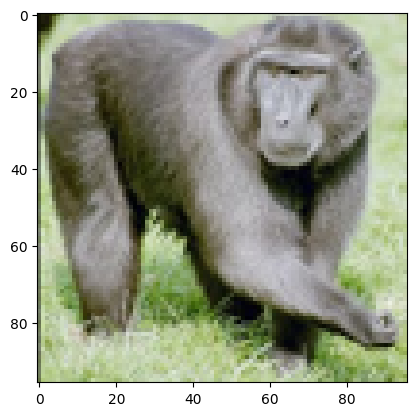

In [8]:
img = images[0]
plt.imshow(img)
plt.show()

In [11]:
def resize_images(array_of_images):
    num_images = len(array_of_images)
    resized_images = []

    # Placeholder for input images
    input_images = tf1.placeholder(tf.float32, shape=[None, None, None, 3])

    # Resize operation
    resized_image_op = tf1.image.resize_images(input_images, size=[32, 32], method=tf1.image.ResizeMethod.NEAREST_NEIGHBOR)

    with tf1.Session() as sess:
        for image in array_of_images:
            resized_image = sess.run(resized_image_op, feed_dict={input_images: [image]})
            resized_images.append(resized_image[0])  # Append the resized image to the list

    return np.array(resized_images)

In [12]:
resized_images = resize_images(images)
# resized_images.shape
# (100000, 32, 32, 3)

In [13]:
stl_norm_unlab_images = normalize_images(resized_images)

### Load ImageNet

In [ ]:
dataset = tfds.load('imagenet_resized/32x32',
                    split='train',
                    batch_size=-1,
                    as_supervised=True)

In [ ]:
imgnet_train_images, imgnet_train_labels = tfds.as_numpy(dataset)
# imgnet_train_images.shape
# (1281167, 32, 32, 3)

In [ ]:
# Calculate the number of images to keep
num_images = imgnet_train_images.shape[0]
num_keep = 300000 #num_images // 4

# Shuffle the indices
indices = np.arange(num_images)
np.random.shuffle(indices)

# Select the first half of the shuffled indices
selected_indices = indices[:num_keep]

# Create the new arrays with the selected images and labels
imgnet_train_images_reduced = imgnet_train_images[selected_indices]
imgnet_train_labels_reduced = imgnet_train_labels[selected_indices]

# Clean up to free memory
del imgnet_train_images
del imgnet_train_labels

# Now imgnet_train_images_reduced and imgnet_train_labels_reduced contain the reduced dataset
print(imgnet_train_images_reduced.shape)
print(imgnet_train_labels_reduced.shape)

(300000, 32, 32, 3)
(300000,)


In [3]:
path = '/content/drive/MyDrive/ColabNotebooks/Cognition and Computation/'

In [ ]:
#imgnet_norm_train_images, imgnet_mean, imgnet_std = normalize_images(imgnet_train_images_reduced)
imgnet_norm_train_images = normalize_images(imgnet_train_images_reduced)
# imgnet_norm_train_images.shape
# (300000, 3072)

In [ ]:
np.save(path+'imgnet_norm_train_images', imgnet_norm_train_images)

Since downloading and saving the images takes a while, to speed things up on subsequent runs it is easier to load the images from where it was saved.

In [4]:
imgnet_norm_train_images = np.load(path+'imgnet_norm_train_images.npy')

### Load CIFAR

In [9]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels_normal),(test_images, test_labels_normal) = cifar10.load_data()

# one hot encoding
train_labels = to_categorical(train_labels_normal,10)
test_labels = to_categorical(test_labels_normal,10)

#train_norm_images, train_mean, train_std = normalize_images(train_images)
#test_norm_images, test_mean, test_std = normalize_images(test_images)

train_norm_images = normalize_images(train_images)
test_norm_images = normalize_images(test_images)

# labels dictionary -> maps the numerical value to the item label
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
labels_dict = {
    i : classes[i]
    for i in range(10)
}

### Performing Principal Component Analysis

In an attempt to reduce the computational load, I did perform a few runs of the notebook using the data set after performing PCA.

I tried using the datasets using the top 1200 principal components, the top 2028 principal components, and all 3072 components but after reconstruction from the top 1200 (as a noise reduction technique).

In the case of PCA with 1200 components the performance on the test set was 36.62% accuracy and in all other cases the reconstruction error was NaN resulting in accuracies of 10%. In the end I decided performing PCA was not worth the deterioration in performance.

The final models do not use PCA but the code for some of the experiments is still reported below.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca_train_images = pca.fit_transform(train_norm_images)

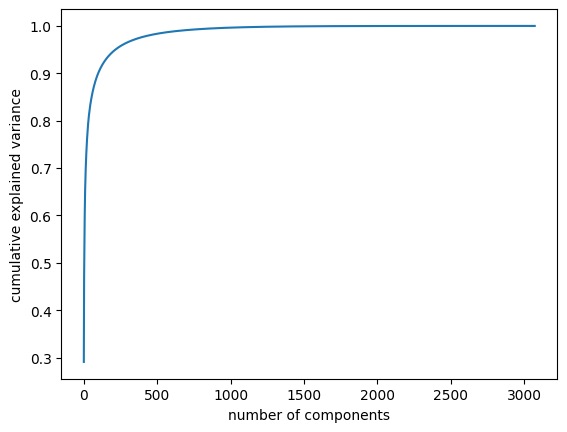

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
np.sum(pca.explained_variance_ratio_[:1200])

0.998007119907137

In [ ]:
pca_1200 = PCA(n_components = 1200)

In [ ]:
train_pca1200_images = pca_1200.fit_transform(train_norm_images)
unsup_train_pca1200_images = pca_1200.transform(stl_norm_unlab_images)
test_pca1200_images = pca_1200.transform(test_norm_images)

In [ ]:
pca_2028 = PCA(n_components = 2028)

In [ ]:
train_pca2028_images = pca_2028.fit_transform(train_norm_images)
unsup_train_pca2028_images = pca_2028.transform(stl_norm_unlab_images)
test_pca2028_images = pca_2028.transform(test_norm_images)

In [ ]:
# PCA 1200 if using STL for pretraining and then CIFAR for finetuning
unsupervised_training_images = unsup_train_pca1200_images
supervised_training_images = train_pca1200_images
supervised_training_labels = train_labels
test_images = test_pca1200_images

In [ ]:
# PCA 2028 if using STL for pretraining and then CIFAR for finetuning
unsupervised_training_images = unsup_train_pca2028_images
supervised_training_images = train_pca2028_images
supervised_training_labels = train_labels
test_images = test_pca2028_images

In [ ]:
# Performing PCA and the reconstruction (as a noise removal technique)
unsup_train_pca1200_images = reconstruct_images(unsup_train_pca1200_images, pca_1200)
train_pca1200_images = reconstruct_images(train_pca1200_images, pca_1200)
test_pca1200_images = reconstruct_images(test_pca1200_images, pca_1200)

In [ ]:
dataset = data_handler.DATA_HANDLER(unsupervised_training_images,
                                    supervised_training_images,
                                    supervised_training_labels,
                                    test_images,
                                    test_labels)

PCA with 1200 components

In [ ]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

my_cdbn_2c = cdbn.CDBN(name = 'cifar10_cdbn_2c',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
my_cdbn_2c.add_layer('layer_1', fully_connected = False,
                  v_height = 20, v_width = 20, v_channels = 3,    # input dimension
                  f_height = 5, f_width = 5, f_number = 24,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
my_cdbn_2c.add_layer('layer_2', fully_connected = False,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 9, f_width = 9, f_number = 64,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = True,
                  padding = True,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
my_cdbn_2c.add_softmax_layer(10,  # classes
                          0.1) # learning rate

my_cdbn_2c.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN cifar10_cdbn_2c with configuration of:
Visible: (20,20,3)
Filters: (5,5,24)
Hidden:  (20,20,24)
--------------------------
Successfully adding convolutional layer layer_2 to CDBN cifar10_cdbn_2c with configuration of:
Visible: (10,10,24)
Filters: (9,9,64)
Hidden:  (10,10,64)
--------------------------
Successfully added softmax layer to the CDBN cifar10_cdbn_2c
--------------------------
Successfully locked the CDBN cifar10_cdbn_2c


In [ ]:
# tf.debugging.enable_check_numerics() # to debug nan's

my_cdbn_2c.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [20000,40000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN cifar10_cdbn_2c
--------------------------
Successfully initialized the layer layer_2 of CDBN cifar10_cdbn_2c
--------------------------
Successfully initialized the softmax layer of CDBN cifar10_cdbn_2c
--------------------------
Starting training the layer layer_1 of CDBN cifar10_cdbn_2c
--------------------------
Step 500: reconstruction error = 45110.66166 (0.010 sec)  -----  Estimated remaining time is 221 sec
Step 1000: reconstruction error = 41134.49384 (0.010 sec)  -----  Estimated remaining time is 199 sec
Step 1500: reconstruction error = 25381.69619 (0.010 sec)  -----  Estimated remaining time is 179 sec
Step 2000: reconstruction error = 23366.47501 (0.009 sec)  -----  Estimated remaining time is 175 sec
Step 2500: reconstruction error = 19916.53523 (0.010 sec)  -----  Estimated remaining time is 170 sec
Step 3000: reconstruction error = 19519.40609 (0.010 sec)  -----  Estimated remaining time is 1

In [ ]:
train_accuracy, test_accuracy = my_cdbn_2c.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 18850 examples are correctly classified out of 50000 total examples
 Accuracy is 37.70 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 3662 examples are correctly classified out of 10000 total examples
 Accuracy is 36.62 percent


PCA with 3072 components reconstructed (NaN during training)

In [ ]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

my_cdbn_2c = cdbn.CDBN(name = 'cifar10_cdbn_2c',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
my_cdbn_2c.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 7, f_width = 7, f_number = 24,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.1,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
my_cdbn_2c.add_layer('layer_2', fully_connected = False,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 11, f_width = 11, f_number = 64,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = True,
                  padding = True,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
my_cdbn_2c.add_softmax_layer(10,  # classes
                          0.1) # learning rate

my_cdbn_2c.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


--------------------------
Successfully adding convolutional layer layer_1 to CDBN cifar10_cdbn_2c with configuration of:
Visible: (32,32,3)
Filters: (7,7,24)
Hidden:  (32,32,24)
--------------------------
Successfully adding convolutional layer layer_2 to CDBN cifar10_cdbn_2c with configuration of:
Visible: (16,16,24)
Filters: (11,11,64)
Hidden:  (16,16,64)
--------------------------
Successfully added softmax layer to the CDBN cifar10_cdbn_2c
--------------------------
Successfully locked the CDBN cifar10_cdbn_2c


In [ ]:
# tf.debugging.enable_check_numerics() # to debug nan's

my_cdbn_2c.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [20000,40000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


--------------------------
Successfully initialized the layer layer_1 of CDBN cifar10_cdbn_2c
--------------------------
Successfully initialized the layer layer_2 of CDBN cifar10_cdbn_2c
--------------------------
Successfully initialized the softmax layer of CDBN cifar10_cdbn_2c
--------------------------
Starting training the layer layer_1 of CDBN cifar10_cdbn_2c
--------------------------
Step 500: reconstruction error = nan (0.033 sec)  -----  Estimated remaining time is 735 sec


KeyboardInterrupt: 

In [ ]:
train_accuracy, test_accuracy = my_cdbn_2c.do_eval()

### Setting parameters for the dataloader

In [ ]:
# if using CIFAR only
unsupervised_training_images = train_images
supervised_training_images = train_images
supervised_training_labels = train_labels

In [10]:
# if using IMAGENET for pretraining and then CIFAR for finetuning
unsupervised_training_images = imgnet_norm_train_images
supervised_training_images = train_images
supervised_training_labels = train_labels

In [26]:
# if using STL for pretraining and then CIFAR for finetuning
unsupervised_training_images = stl_norm_unlab_images
supervised_training_images = train_images
supervised_training_labels = train_labels

In [11]:
dataset = data_handler.DATA_HANDLER(unsupervised_training_images,
                                    supervised_training_images,
                                    supervised_training_labels,
                                    test_images,
                                    test_labels)

## Data Combo 1 : STL-10 for pre-training, CIFAR-10 for fine-tuning

### **Model 1** : Vanilla RBM with 2 Fully Connected Layers

In [ ]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

stlcif_cdbn_2fc = cdbn.CDBN(name = 'stl10-cifar10_cdbn_2fc',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
stlcif_cdbn_2fc.add_layer('layer_1', fully_connected = True,
                  v_height = 1, v_width = 1, v_channels = 3072,    # input dimension
                  f_height = 1, f_width = 1, f_number = 64,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = False,                         # probability max pooling is used
                  padding = False,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
stlcif_cdbn_2fc.add_layer('layer_2', fully_connected = True,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 1, f_width = 1, f_number = 32,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding =False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
stlcif_cdbn_2fc.add_softmax_layer(10,  # classes
                          0.1) # learning rate

stlcif_cdbn_2fc.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding fully connected layer layer_1 to CDBN stl10-cifar10_cdbn_2fc with has 3072 visible units and 64 hidden units 
--------------------------
Successfully adding fully connected layer layer_2 to CDBN stl10-cifar10_cdbn_2fc with has 64 visible units and 32 hidden units 
--------------------------
Successfully added softmax layer to the CDBN stl10-cifar10_cdbn_2fc
--------------------------
Successfully locked the CDBN stl10-cifar10_cdbn_2fc


In [ ]:
# tf.debugging.enable_check_numerics() # to debug nan's

stlcif_cdbn_2fc.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN stl10-cifar10_cdbn_2fc
--------------------------
Successfully initialized the layer layer_2 of CDBN stl10-cifar10_cdbn_2fc
--------------------------
Successfully initialized the softmax layer of CDBN stl10-cifar10_cdbn_2fc
--------------------------
Starting training the layer layer_1 of CDBN stl10-cifar10_cdbn_2fc
--------------------------
Step 500: reconstruction error = 64465.78705 (0.005 sec)  -----  Estimated remaining time is 13 sec
Step 1000: reconstruction error = 53963.75679 (0.006 sec)  -----  Estimated remaining time is 8 sec
Step 1500: reconstruction error = 40287.57431 (0.004 sec)  -----  Estimated remaining time is 4 sec
Step 2000: reconstruction error = 39243.10952 (0.004 sec)  -----  Estimated remaining time is 2 sec
--------------------------
Successfully trained the layer layer_1 of CDBN stl10-cifar10_cdbn_2fc in 12 sec
--------------------------
Starting training the layer layer_2 of CDB

In [ ]:
train_accuracy, test_accuracy = stlcif_cdbn_2fc.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 10312 examples are correctly classified out of 50000 total examples
 Accuracy is 20.62 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 2101 examples are correctly classified out of 10000 total examples
 Accuracy is 21.01 percent


### **Model 2** : CRBM with 2 conv layers

In [36]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

stlcif_cdbn_2c = cdbn.CDBN(name = 'stl10-cifar10_cdbn_2c',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
stlcif_cdbn_2c.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 7, f_width = 7, f_number = 24,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
stlcif_cdbn_2c.add_layer('layer_2', fully_connected = False,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 11, f_width = 11, f_number = 50,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = True,
                  padding = True,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
stlcif_cdbn_2c.add_softmax_layer(10,  # classes
                          0.1) # learning rate

stlcif_cdbn_2c.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN stl10-cifar10_cdbn_2c with configuration of:
Visible: (32,32,3)
Filters: (7,7,24)
Hidden:  (32,32,24)
--------------------------
Successfully adding convolutional layer layer_2 to CDBN stl10-cifar10_cdbn_2c with configuration of:
Visible: (16,16,24)
Filters: (11,11,50)
Hidden:  (16,16,50)
--------------------------
Successfully added softmax layer to the CDBN stl10-cifar10_cdbn_2c
--------------------------
Successfully locked the CDBN stl10-cifar10_cdbn_2c


In [37]:
# tf.debugging.enable_check_numerics() # to debug nan's

stlcif_cdbn_2c.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN stl10-cifar10_cdbn_2c
--------------------------
Successfully initialized the layer layer_2 of CDBN stl10-cifar10_cdbn_2c
--------------------------
Successfully initialized the softmax layer of CDBN stl10-cifar10_cdbn_2c
--------------------------
Starting training the layer layer_1 of CDBN stl10-cifar10_cdbn_2c
--------------------------
Step 500: reconstruction error = 46639.26703 (0.034 sec)  -----  Estimated remaining time is 70 sec
Step 1000: reconstruction error = 44658.53419 (0.033 sec)  -----  Estimated remaining time is 52 sec
Step 1500: reconstruction error = 43650.36305 (0.034 sec)  -----  Estimated remaining time is 34 sec
Step 2000: reconstruction error = 43759.90261 (0.033 sec)  -----  Estimated remaining time is 17 sec
--------------------------
Successfully trained the layer layer_1 of CDBN stl10-cifar10_cdbn_2c in 85 sec
--------------------------
Starting training the layer layer_2 of CDBN 

In [38]:
train_accuracy, test_accuracy = stlcif_cdbn_2c.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 23675 examples are correctly classified out of 50000 total examples
 Accuracy is 47.35 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 4201 examples are correctly classified out of 10000 total examples
 Accuracy is 42.01 percent


### **Model 3** : CRBM with 1 conv, 1 fc layer

In [33]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

stlcif_cdbn_1c1fc = cdbn.CDBN(name = 'stl10-cifar10_cdbn_1c1fc',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
stlcif_cdbn_1c1fc.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 9, f_width = 9, f_number = 64,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.005,
                  gaussian_unit = True, gaussian_variance = 0.02,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.25, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
stlcif_cdbn_1c1fc.add_layer('layer_2', fully_connected = True,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 1, f_width = 1, f_number = 32,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding =False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
stlcif_cdbn_1c1fc.add_softmax_layer(10,  # classes
                          0.1) # learning rate

stlcif_cdbn_1c1fc.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN stl10-cifar10_cdbn_1c1fc with configuration of:
Visible: (32,32,3)
Filters: (9,9,64)
Hidden:  (32,32,64)
--------------------------
Successfully adding fully connected layer layer_2 to CDBN stl10-cifar10_cdbn_1c1fc with has 16384 visible units and 32 hidden units 
--------------------------
Successfully added softmax layer to the CDBN stl10-cifar10_cdbn_1c1fc
--------------------------
Successfully locked the CDBN stl10-cifar10_cdbn_1c1fc


In [35]:
# tf.debugging.enable_check_numerics() # to debug nan's

stlcif_cdbn_1c1fc.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN stl10-cifar10_cdbn_1c1fc
--------------------------
Successfully initialized the layer layer_2 of CDBN stl10-cifar10_cdbn_1c1fc
--------------------------
Successfully initialized the softmax layer of CDBN stl10-cifar10_cdbn_1c1fc
--------------------------
Starting training the layer layer_1 of CDBN stl10-cifar10_cdbn_1c1fc
--------------------------
Step 500: reconstruction error = nan (0.081 sec)  -----  Estimated remaining time is 163 sec
Step 1000: reconstruction error = nan (0.080 sec)  -----  Estimated remaining time is 121 sec
Step 1500: reconstruction error = nan (0.081 sec)  -----  Estimated remaining time is 81 sec
Step 2000: reconstruction error = nan (0.081 sec)  -----  Estimated remaining time is 40 sec
--------------------------
Successfully trained the layer layer_1 of CDBN stl10-cifar10_cdbn_1c1fc in 202 sec
--------------------------
Starting training the layer layer_2 of CDBN stl10-cifar10_

In [ ]:
train_accuracy, test_accuracy = stlcif_cdbn_1c1fc.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 5000 examples are correctly classified out of 50000 total examples
 Accuracy is 10.00 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 1000 examples are correctly classified out of 10000 total examples
 Accuracy is 10.00 percent


### **Model 4** : CRBM with 1 conv, 1 global and 1 fc layer

In [ ]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

my_cdbn = cdbn.CDBN(name = 'cifar10_cdbn',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
my_cdbn.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 9, f_width = 9, f_number = 64,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
my_cdbn.add_layer('global_layer_1', fully_connected = True,
                  v_height = 1, v_width = 1, v_channels = 3072, #6144 = 3072*2 = (32*32*3)*2
                  f_height = 1, f_width = 1, f_number = 1024,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = True, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding = False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4,
                  global_layer = True)

my_cdbn.add_layer('layer_2', fully_connected = True,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 1, f_width = 1, f_number = 200,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding = False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
my_cdbn.add_softmax_layer(10,  # classes
                          0.1) # learning rate

my_cdbn.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN cifar10_cdbn with configuration of:
Visible: (32,32,3)
Filters: (9,9,64)
Hidden:  (32,32,64)
--------------------------
Successfully adding fully connected layer global_layer_1 to CDBN cifar10_cdbn with has 3072 visible units and 1024 hidden units 
--------------------------
Successfully adding fully connected layer layer_2 to CDBN cifar10_cdbn with has 16384 visible units and 200 hidden units 
--------------------------
Successfully added softmax layer to the CDBN cifar10_cdbn
--------------------------
Successfully locked the CDBN cifar10_cdbn


In [ ]:
my_cdbn.manage_layers(['layer_1','global_layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000,20000], # for each layer, the number of training epochs
                      [1,1,1], # for each layer, length of the Gibbs chain in Gibbs sampling
                      25000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN cifar10_cdbn
--------------------------
Successfully initialized the layer global_layer_1 of CDBN cifar10_cdbn
--------------------------
Successfully initialized the layer layer_2 of CDBN cifar10_cdbn
--------------------------
Successfully initialized the softmax layer of CDBN cifar10_cdbn
--------------------------
Starting training the layer layer_1 of CDBN cifar10_cdbn
--------------------------
Step 500: reconstruction error = 39187.11909 (0.069 sec)  -----  Estimated remaining time is 141 sec
Step 1000: reconstruction error = 34649.38238 (0.068 sec)  -----  Estimated remaining time is 105 sec
Step 1500: reconstruction error = 29274.66177 (0.068 sec)  -----  Estimated remaining time is 68 sec
Step 2000: reconstruction error = 29373.78306 (0.068 sec)  -----  Estimated remaining time is 34 sec
--------------------------
Successfully trained the layer layer_1 of CDBN cifar10_cdbn in 172 sec
---------------

In [ ]:
train_accuracy, test_accuracy = my_cdbn.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 26475 examples are correctly classified out of 50000 total examples
 Accuracy is 52.95 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 4833 examples are correctly classified out of 10000 total examples
 Accuracy is 48.33 percent


## Data Combo 2 : ImageNET for pre-training, CIFAR-10 for fine-tuning

### **Model 1** : Vanilla RBM with 2 Fully Connected Layers

In [ ]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

imnetcif_cdbn_2fc = cdbn.CDBN(name = 'imgnet-cifar10_cdbn_2fc',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
imnetcif_cdbn_2fc.add_layer('layer_1', fully_connected = True,
                  v_height = 1, v_width = 1, v_channels = 3072,    # input dimension
                  f_height = 1, f_width = 1, f_number = 64,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = False,                         # probability max pooling is used
                  padding = False,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
imnetcif_cdbn_2fc.add_layer('layer_2', fully_connected = True,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 1, f_width = 1, f_number = 32,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding =False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
imnetcif_cdbn_2fc.add_softmax_layer(10,  # classes
                          0.1) # learning rate

imnetcif_cdbn_2fc.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding fully connected layer layer_1 to CDBN imgnet-cifar10_cdbn_2fc with has 3072 visible units and 64 hidden units 
--------------------------
Successfully adding fully connected layer layer_2 to CDBN imgnet-cifar10_cdbn_2fc with has 64 visible units and 32 hidden units 
--------------------------
Successfully added softmax layer to the CDBN imgnet-cifar10_cdbn_2fc
--------------------------
Successfully locked the CDBN imgnet-cifar10_cdbn_2fc


In [ ]:
# tf.debugging.enable_check_numerics() # to debug nan's

imnetcif_cdbn_2fc.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN imgnet-cifar10_cdbn_2fc
--------------------------
Successfully initialized the layer layer_2 of CDBN imgnet-cifar10_cdbn_2fc
--------------------------
Successfully initialized the softmax layer of CDBN imgnet-cifar10_cdbn_2fc
--------------------------
Starting training the layer layer_1 of CDBN imgnet-cifar10_cdbn_2fc
--------------------------
Step 500: reconstruction error = 66295.29774 (0.005 sec)  -----  Estimated remaining time is 13 sec
Step 1000: reconstruction error = 54089.12992 (0.005 sec)  -----  Estimated remaining time is 9 sec
Step 1500: reconstruction error = 39685.67782 (0.005 sec)  -----  Estimated remaining time is 5 sec
Step 2000: reconstruction error = 38937.91938 (0.020 sec)  -----  Estimated remaining time is 2 sec
--------------------------
Successfully trained the layer layer_1 of CDBN imgnet-cifar10_cdbn_2fc in 13 sec
--------------------------
Starting training the layer layer_2 o

In [ ]:
train_accuracy, test_accuracy = imnetcif_cdbn_2fc.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 9032 examples are correctly classified out of 50000 total examples
 Accuracy is 18.06 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 1803 examples are correctly classified out of 10000 total examples
 Accuracy is 18.03 percent


### **Model 2** : CRBM with 2 conv layers

In [162]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess_dc2_m2 = tf1.Session()

batch_size = 200

imnetcif_cdbn_2c = cdbn.CDBN(name = 'imgnet-cifar10_cdbn_2c',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess_dc2_m2,
                    verbosity = 1)

# first layer
imnetcif_cdbn_2c.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 7, f_width = 7, f_number = 24,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
imnetcif_cdbn_2c.add_layer('layer_2', fully_connected = False,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 11, f_width = 11, f_number = 50,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = True,
                  padding = True,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
imnetcif_cdbn_2c.add_softmax_layer(10,  # classes
                          0.1) # learning rate

imnetcif_cdbn_2c.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN imgnet-cifar10_cdbn_2c with configuration of:
Visible: (32,32,3)
Filters: (7,7,24)
Hidden:  (32,32,24)
--------------------------
Successfully adding convolutional layer layer_2 to CDBN imgnet-cifar10_cdbn_2c with configuration of:
Visible: (16,16,24)
Filters: (11,11,50)
Hidden:  (16,16,50)
--------------------------
Successfully added softmax layer to the CDBN imgnet-cifar10_cdbn_2c
--------------------------
Successfully locked the CDBN imgnet-cifar10_cdbn_2c


In [163]:
# tf.debugging.enable_check_numerics() # to debug nan's

imnetcif_cdbn_2c.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN imgnet-cifar10_cdbn_2c
--------------------------
Successfully initialized the layer layer_2 of CDBN imgnet-cifar10_cdbn_2c
--------------------------
Successfully initialized the softmax layer of CDBN imgnet-cifar10_cdbn_2c
--------------------------
Starting training the layer layer_1 of CDBN imgnet-cifar10_cdbn_2c
--------------------------
Step 500: reconstruction error = 45488.73237 (0.033 sec)  -----  Estimated remaining time is 69 sec
Step 1000: reconstruction error = 45120.80077 (0.033 sec)  -----  Estimated remaining time is 51 sec
Step 1500: reconstruction error = 44573.36213 (0.033 sec)  -----  Estimated remaining time is 33 sec
Step 2000: reconstruction error = 44329.86298 (0.033 sec)  -----  Estimated remaining time is 17 sec
--------------------------
Successfully trained the layer layer_1 of CDBN imgnet-cifar10_cdbn_2c in 84 sec
--------------------------
Starting training the layer layer_2 of 

In [164]:
train_accuracy, test_accuracy = imnetcif_cdbn_2c.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 22993 examples are correctly classified out of 50000 total examples
 Accuracy is 45.99 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 4066 examples are correctly classified out of 10000 total examples
 Accuracy is 40.66 percent


### **Model 3** : CRBM with 1 conv, 1 fc layer

In [ ]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess = tf1.Session()

batch_size = 200

imnetcif_cdbn_1c1fc = cdbn.CDBN(name = 'imgnet-cifar10_cdbn_1c1fc',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess,
                    verbosity = 1)

# first layer
imnetcif_cdbn_1c1fc.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 9, f_width = 9, f_number = 64,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
imnetcif_cdbn_1c1fc.add_layer('layer_2', fully_connected = True,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 1, f_width = 1, f_number = 32,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding =False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
imnetcif_cdbn_1c1fc.add_softmax_layer(10,  # classes
                          0.1) # learning rate

imnetcif_cdbn_1c1fc.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN imgnet-cifar10_cdbn_1c1fc with configuration of:
Visible: (32,32,3)
Filters: (9,9,64)
Hidden:  (32,32,64)
--------------------------
Successfully adding fully connected layer layer_2 to CDBN imgnet-cifar10_cdbn_1c1fc with has 16384 visible units and 32 hidden units 
--------------------------
Successfully added softmax layer to the CDBN imgnet-cifar10_cdbn_1c1fc
--------------------------
Successfully locked the CDBN imgnet-cifar10_cdbn_1c1fc


In [ ]:
# tf.debugging.enable_check_numerics() # to debug nan's

imnetcif_cdbn_1c1fc.manage_layers(['layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000], # for each layer, the number of training epochs
                      [2,2], # for each layer, length of the Gibbs chain in Gibbs sampling
                      50000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN imgnet-cifar10_cdbn_1c1fc
--------------------------
Successfully initialized the layer layer_2 of CDBN imgnet-cifar10_cdbn_1c1fc
--------------------------
Successfully initialized the softmax layer of CDBN imgnet-cifar10_cdbn_1c1fc
--------------------------
Starting training the layer layer_1 of CDBN imgnet-cifar10_cdbn_1c1fc
--------------------------
Step 500: reconstruction error = nan (0.081 sec)  -----  Estimated remaining time is 166 sec
Step 1000: reconstruction error = nan (0.082 sec)  -----  Estimated remaining time is 123 sec
Step 1500: reconstruction error = nan (0.081 sec)  -----  Estimated remaining time is 81 sec
Step 2000: reconstruction error = nan (0.081 sec)  -----  Estimated remaining time is 41 sec
--------------------------
Successfully trained the layer layer_1 of CDBN imgnet-cifar10_cdbn_1c1fc in 204 sec
--------------------------
Starting training the layer layer_2 of CDBN imgnet-ci

In [ ]:
train_accuracy, test_accuracy = imnetcif_cdbn_1c1fc.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 5000 examples are correctly classified out of 50000 total examples
 Accuracy is 10.00 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 1000 examples are correctly classified out of 10000 total examples
 Accuracy is 10.00 percent


### **Model 4** : CRBM with 1 conv, 1 global and 1 fc layer

In [183]:
# for the tensorflow graph session
tf1.reset_default_graph()
sess_dc2_m4 = tf1.Session()

batch_size = 200

imnetcif_cdbn_glob = cdbn.CDBN(name = 'imgnet-cifar10_cdbn_glob',
                    batch_size = batch_size,
                    path = '/home/', # saving the model
                    data = dataset, # data handler
                    session = sess_dc2_m4,
                    verbosity = 1)

# first layer
imnetcif_cdbn_glob.add_layer('layer_1', fully_connected = False,
                  v_height = 32, v_width = 32, v_channels = 3,    # input dimension
                  f_height = 9, f_width = 9, f_number = 64,       # convolutional filters dimension
                  init_biases_H = -5, init_biases_V = 0.01, init_weight_stddev = 0.01,
                  gaussian_unit = True, gaussian_variance = 0.2,  # gaussian prior for the input layer
                  prob_maxpooling = True,                         # probability max pooling is used
                  padding = True,                                 # padding is used to preserve the original size of the input image
                  learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000, # learning rate parameters
                  weight_decay = 1.0, sparsity_target = 0.01, sparsity_coef = 0.05) # sparsity and regularization parameters

# second layer
imnetcif_cdbn_glob.add_layer('global_layer_1', fully_connected = True,
                  v_height = 1, v_width = 1, v_channels = 3072, #6144 = 3072*2 = (32*32*3)*2
                  f_height = 1, f_width = 1, f_number = 1024,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = True, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding = False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4,
                  global_layer = True)

imnetcif_cdbn_glob.add_layer('layer_2', fully_connected = True,
                  v_height = "auto", v_width = "auto", v_channels = "auto", # input is automatically calculated from the previous layer output
                  f_height = 1, f_width = 1, f_number = 200,
                  init_biases_H = -5, init_biases_V = 0.025, init_weight_stddev = 0.025,
                  gaussian_unit = False, gaussian_variance = 0.2,
                  prob_maxpooling = False,
                  padding = False,
                  learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,
                  weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.4)


# softmax layer
imnetcif_cdbn_glob.add_softmax_layer(10,  # classes
                          0.1) # learning rate

imnetcif_cdbn_glob.lock_cdbn()

# to be able to run this multiple times
tf1.get_variable_scope().reuse_variables()

--------------------------
Successfully adding convolutional layer layer_1 to CDBN imgnet-cifar10_cdbn_glob with configuration of:
Visible: (32,32,3)
Filters: (9,9,64)
Hidden:  (32,32,64)
--------------------------
Successfully adding fully connected layer global_layer_1 to CDBN imgnet-cifar10_cdbn_glob with has 3072 visible units and 1024 hidden units 
--------------------------
Successfully adding fully connected layer layer_2 to CDBN imgnet-cifar10_cdbn_glob with has 16384 visible units and 200 hidden units 
--------------------------
Successfully added softmax layer to the CDBN imgnet-cifar10_cdbn_glob
--------------------------
Successfully locked the CDBN imgnet-cifar10_cdbn_glob


In [184]:
imnetcif_cdbn_glob.manage_layers(['layer_1','global_layer_1','layer_2'], # the layers to train
                      [], #layers to restore
                      [], #layers to transfer
                      [2500,10000,20000], # for each layer, the number of training epochs
                      [1,1,1], # for each layer, length of the Gibbs chain in Gibbs sampling
                      25000, # epochs for softmax training
                      restore_softmax = False, # for restoring a saved model
                      fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN imgnet-cifar10_cdbn_glob
--------------------------
Successfully initialized the layer global_layer_1 of CDBN imgnet-cifar10_cdbn_glob
--------------------------
Successfully initialized the layer layer_2 of CDBN imgnet-cifar10_cdbn_glob
--------------------------
Successfully initialized the softmax layer of CDBN imgnet-cifar10_cdbn_glob
--------------------------
Starting training the layer layer_1 of CDBN imgnet-cifar10_cdbn_glob
--------------------------
Step 500: reconstruction error = 42478.97508 (0.070 sec)  -----  Estimated remaining time is 140 sec
Step 1000: reconstruction error = 37482.73712 (0.069 sec)  -----  Estimated remaining time is 104 sec
Step 1500: reconstruction error = 30396.25884 (0.068 sec)  -----  Estimated remaining time is 69 sec
Step 2000: reconstruction error = 30255.49393 (0.070 sec)  -----  Estimated remaining time is 34 sec
--------------------------
Successfully trained the l

In [185]:
train_accuracy, test_accuracy = imnetcif_cdbn_glob.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 24164 examples are correctly classified out of 50000 total examples
 Accuracy is 48.33 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 4267 examples are correctly classified out of 10000 total examples
 Accuracy is 42.67 percent


## Analysis

For the analysis we will look at both model 2 which has 2 convolutional layers and model 4 which contains the global layer.

Model 4 performed better than Model 2, so we will use it when looking at the confusion matrix and in the comparison against the CNN.

However, since Model 2 has 2 convolutional layers, we can use it to look at the hierarchical representations.

In [186]:
best_cdbn = imnetcif_cdbn_glob
model2 = imnetcif_cdbn_2c

In [ ]:
# Run this cell with the appropriate session call
#sess = sess_dc2_m2 #for data combo2, model2 i.e. 2 conv layers
#sess = sess_dc2_m4 #for data combo2, model4 i.e. global layer

In [19]:
# utils variables that will be used
data_train_labels = supervised_training_labels.argmax(1).astype("uint8")
data_test_labels = test_labels.argmax(1).astype("uint8")

### Visualizing the confusion matrix

In [91]:
sess = sess_dc2_m4

In [20]:
def softmax_prediction(data,cdbn,batches):

  data = np.reshape(data,(data.shape[0],32,32,3))

  if batches * batch_size > data.shape[0]:
    return -1

  # get the parameters of the softmax layer to perform predictions
  W = cdbn.W.eval(session=sess)
  b = cdbn.b.eval(session=sess)

  # the operation is batched because I get data from the tensorflow graph (which built the model
  # with a batch_size that regulates most of its internal operations). I found no
  # other way than to repeat this "fetching" operation with the size of batch_size
  for i in range(batches):
    batch_samples = tf.reshape(cdbn._get_input_level(2, data[i*batch_size:(i+1)*batch_size,:,:].astype('float32')).eval(session=sess), [batch_size, -1])
    # prediction
    y = tf.nn.softmax(tf.matmul(batch_samples, W) + b).eval(session=sess)
    predicted_class = tf.argmax(y,1).eval(session=sess)
    if i == 0:
      acc = predicted_class
    else:
      acc = np.hstack((acc,predicted_class))
  return acc

In [21]:
# Predict the first 50*200(batch_size)=10000 examples from the test set
softmax_predicted = softmax_prediction(test_images,best_cdbn,50)

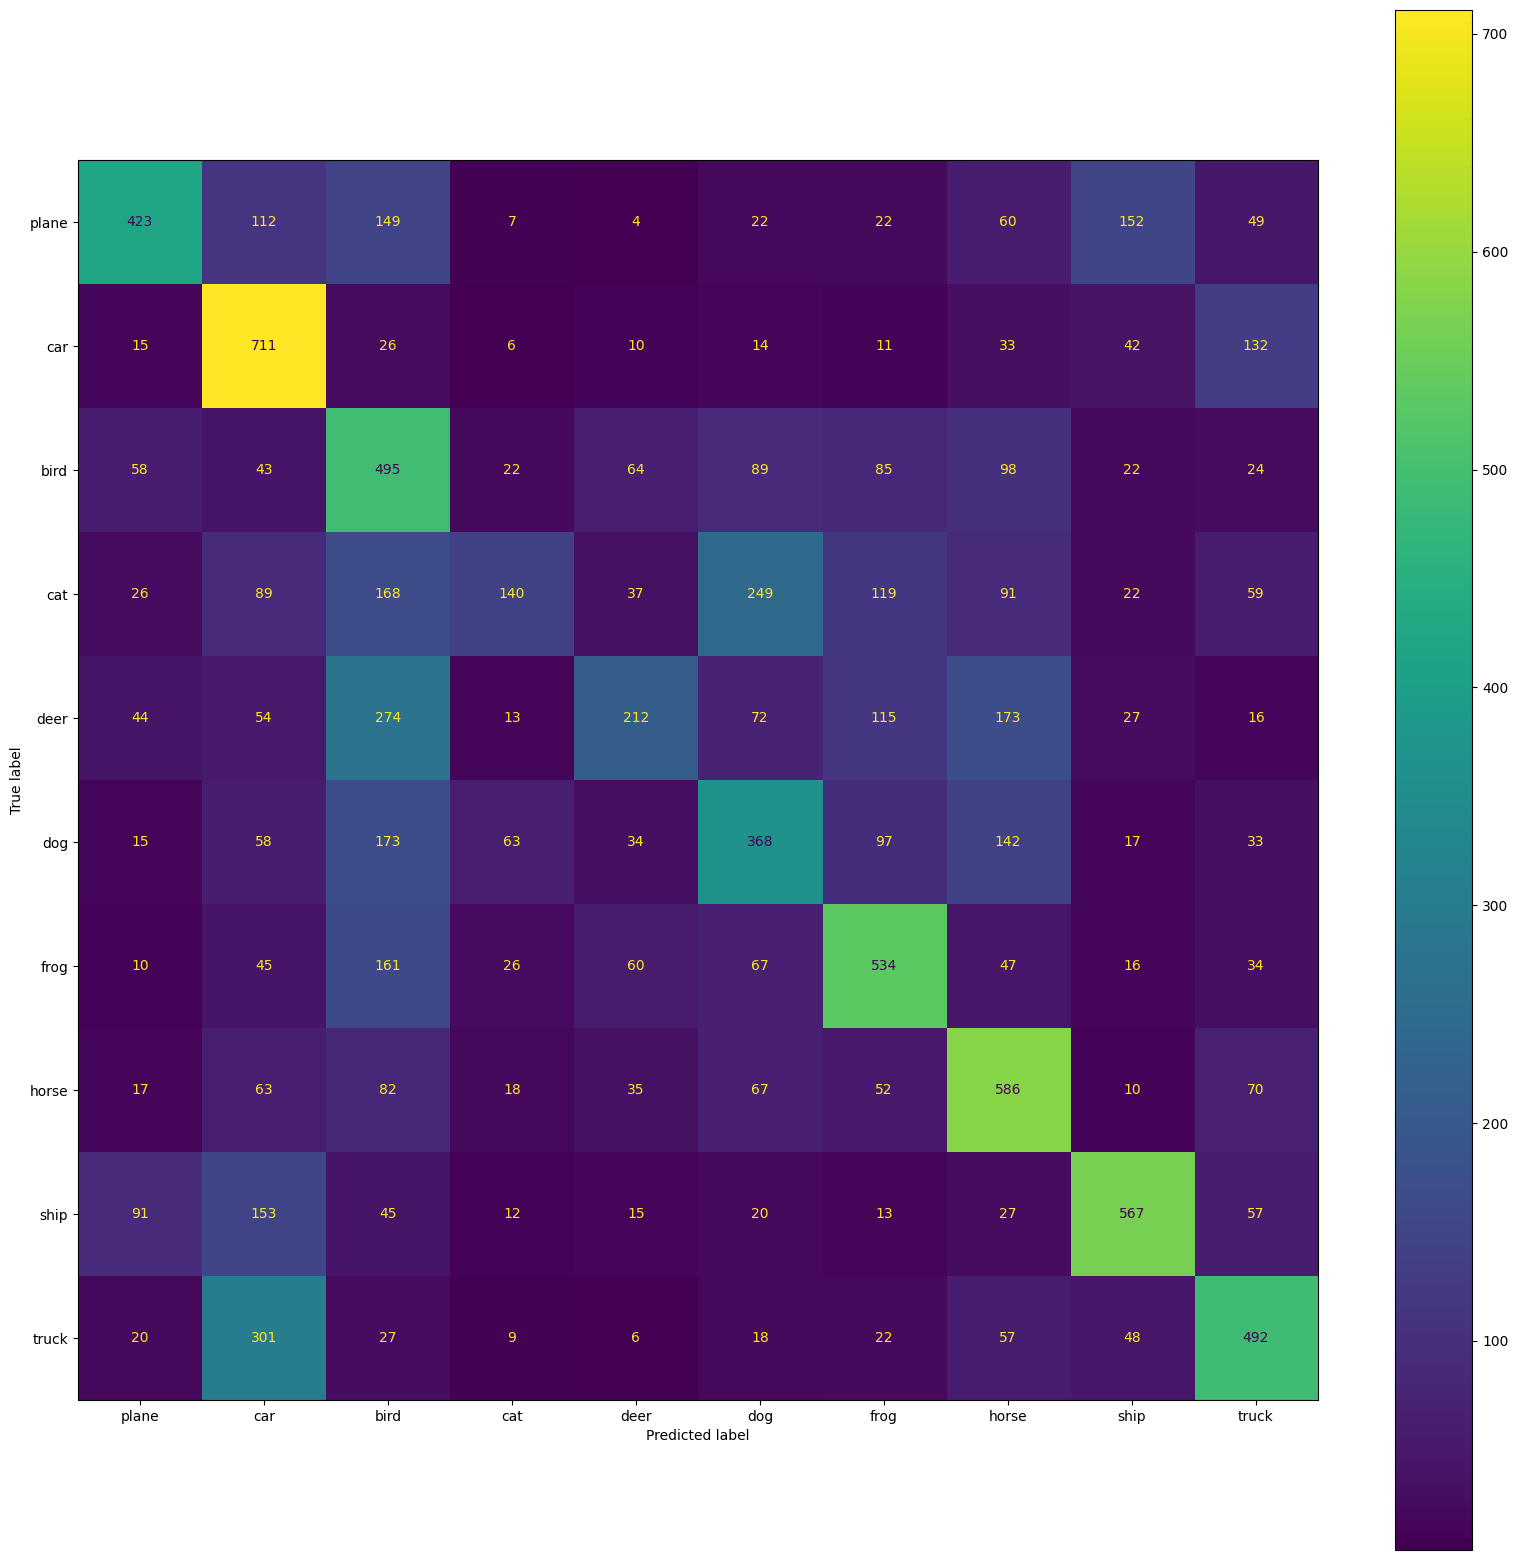

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_confusion_matrix(ground_truth,predictions,classes):
  cm = confusion_matrix(ground_truth, predictions, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  fig, ax = plt.subplots(figsize=(20,20))
  disp.plot(ax=ax)
  plt.show()

print_confusion_matrix([labels_dict[k] for k in data_test_labels[:softmax_predicted.shape[0]]],
                       [labels_dict[k] for k in softmax_predicted],
                       list(labels_dict.values()))

Most of the classes have an accuracy score of over 50%:
- car
- horse
- ship
- frog

The classes with the lowest accuracy are:
- cat 14%
- deer 21%
- dog 37%


Cat is most often confused with dog (25%) and bird (17%).

Deer is most often confused with bird (27%) and horse (17%).

Dog is most often confused with bird (17%) and horse (14%).

This is not surprising as the animal categories probably have features which are quite close to each other, leading to the model having trouble classifying them.

### Visualizing misclassified examples

In [ ]:
import math

# general function that I use to plot images. Some additional parameters allows it
# to visualize the label of an example
def print_images(images,num_subplots,labels=None,labels_dict=None,predictions=None):
  #images = images*255
  num_col = 12
  num_row = math.ceil(num_subplots / num_col)

  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,1.8*num_row),squeeze=False)
  for i in range(num_row * num_col):
      ax = axes[i//num_col, i%num_col]
      ax.set_axis_off()
      if i >= num_subplots: # complete the row with white images if num_subplots is not multiple of num_col
        ax.imshow(np.zeros((images.shape[0],images.shape[0])), cmap='gray_r')
      else:
        if labels is not None and labels_dict is not None and predictions is None:
          ax.set_title("Label: " + labels_dict[labels[i]])
        elif predictions is not None:
          ax.set_title("True: " + labels_dict[labels[i]] + "\nPred: " + labels_dict[predictions[i]])
        ax.imshow(images[i,:,:], cmap='gray')
        #ax.imshow(images[:,:,i], cmap='gray')
  plt.show()

In [ ]:
labels_dict

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

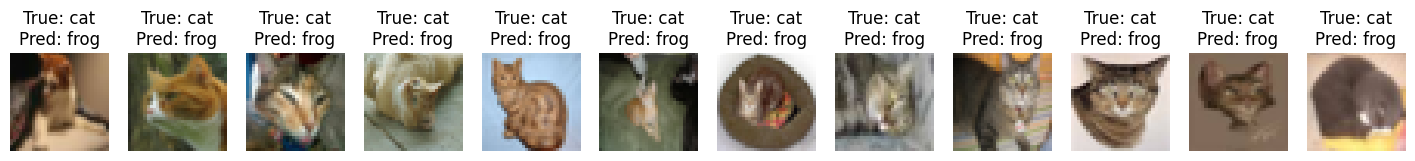

In [56]:
# ground truth: 3 -> cat
# prediction: 6 -> frog
indices_catvfrog = np.all([(data_test_labels[:softmax_predicted.shape[0]]==3), (softmax_predicted==6)], axis=0)
#first_data = test_images[:10000,:]
print_images(test_images[indices_catvfrog],#.swapaxes(0,1).reshape((32,32,np.sum(indices_catvfrog),3)),
             12,
             labels=data_test_labels[:softmax_predicted.shape[0]][indices_catvfrog],
             labels_dict=labels_dict,
             predictions=softmax_predicted[indices_catvfrog])

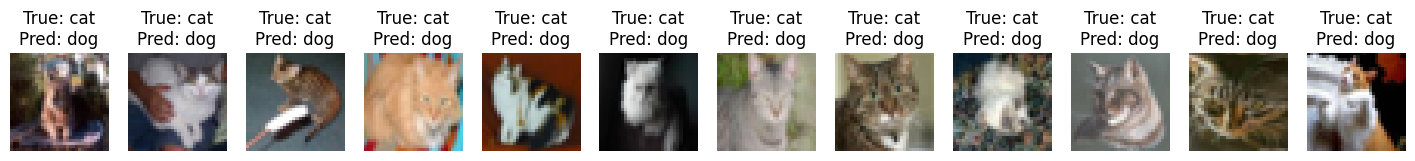

In [41]:
# ground truth: 3 -> cat
# prediction: 5 -> dog
indices_catvdog = np.all([ (data_test_labels[:softmax_predicted.shape[0]]==3), (softmax_predicted==5) ], axis=0)
first_data = test_images[:10000,:]
print_images(first_data[indices_catvdog],#.swapaxes(0,1).reshape((32,32,np.sum(indices_catvdog),3)),
             12,
             labels=data_test_labels[:softmax_predicted.shape[0]][indices_catvdog],
             labels_dict=labels_dict,
             predictions=softmax_predicted[indices_catvdog])

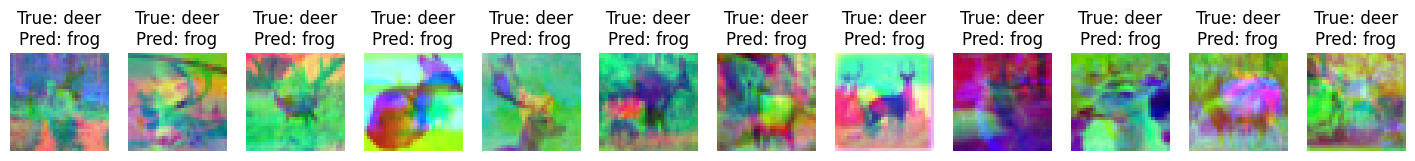

In [ ]:
# ground truth: 4 -> deer
# prediction: 6 -> frog
indices_deervfrog = np.all([ (data_test_labels[:softmax_predicted.shape[0]]==4), (softmax_predicted==6) ], axis=0)

print_images(first_data[indices_deervfrog],
             12,
             labels=data_test_labels[:softmax_predicted.shape[0]][indices_deervfrog],
             labels_dict=labels_dict,
             predictions=softmax_predicted[indices_deervfrog])

### Visualizing filters

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_subplot(filters_layer, num_channels=None, num_filters=None, combined=False):
    if num_filters is None:
        num_filters = filters_layer.shape[3]
    if num_channels is None:
        num_channels = filters_layer.shape[2]

    for i in range(num_channels):
        print("--- Channel", i + 1, "---")
        plot_channel(filters_layer[:, :, i, :], num_filters)

    if combined:
        print("--- Combined RGB ---")
        plot_combined(filters_layer, num_filters)

def normalize_filters(filters):
    min_val = filters.min()
    max_val = filters.max()
    return (filters - min_val) / (max_val - min_val)

def plot_channel(filters, num_filters):
    num_col = 16
    num_row = math.ceil(num_filters / num_col)

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 1.8 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.set_axis_off()
        if i >= num_filters:
            ax.imshow(np.zeros((filters.shape[0], filters.shape[1])), cmap='gray')
        else:
            ax.imshow(normalize_filters(filters[:, :, i]), cmap='gray')
    plt.show()

def plot_combined(filters_layer, num_filters):
    num_col = 16
    num_row = math.ceil(num_filters / num_col)

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 1.8 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.set_axis_off()
        if i >= num_filters:
            ax.imshow(np.zeros((filters_layer.shape[0], filters_layer.shape[1], 3)))
        else:
            combined_filter = normalize_filters(filters_layer[:, :, :, i])
            ax.imshow(combined_filter)
    plt.show()

#### Filters for Model 4
Model 4 only has 1 convolutional layer. So we can only visualize the filters in the first layer as there are no other filters to see.

--- Channel 1 ---


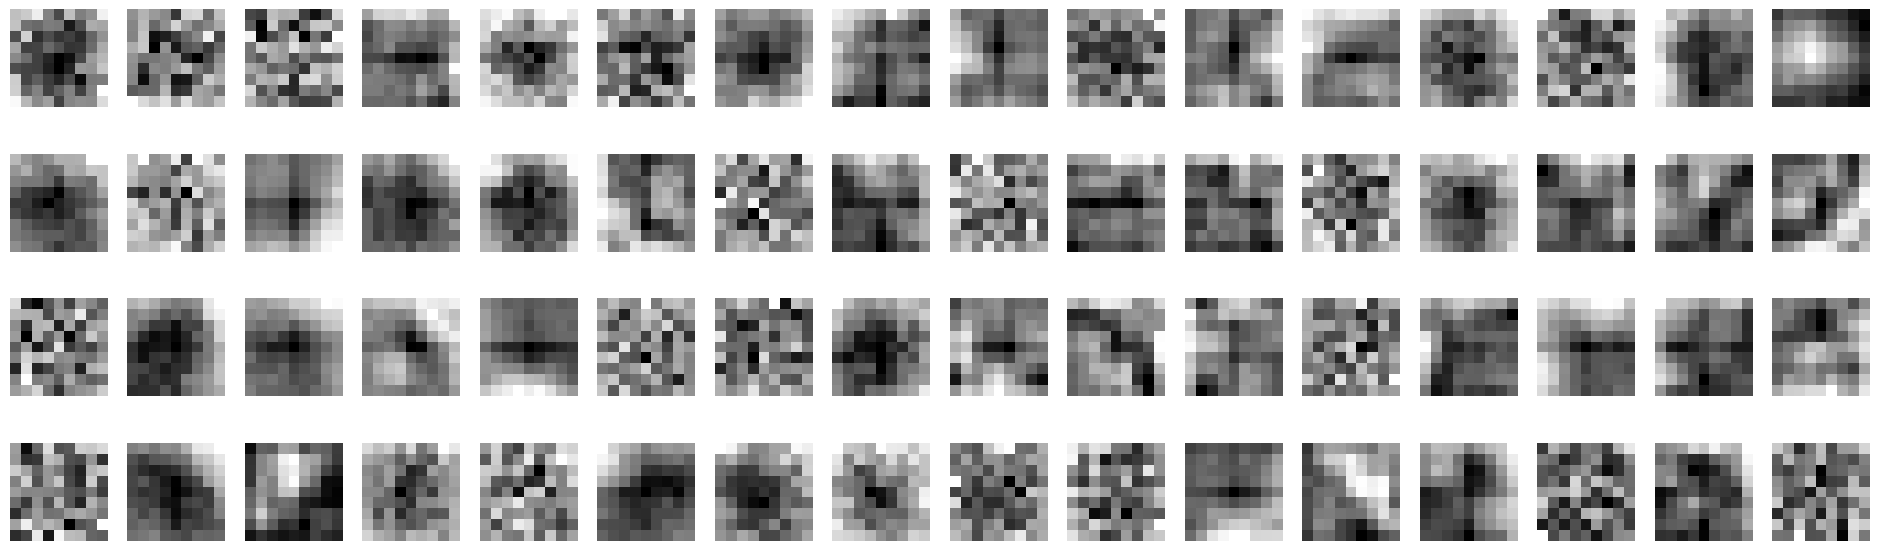

--- Channel 2 ---


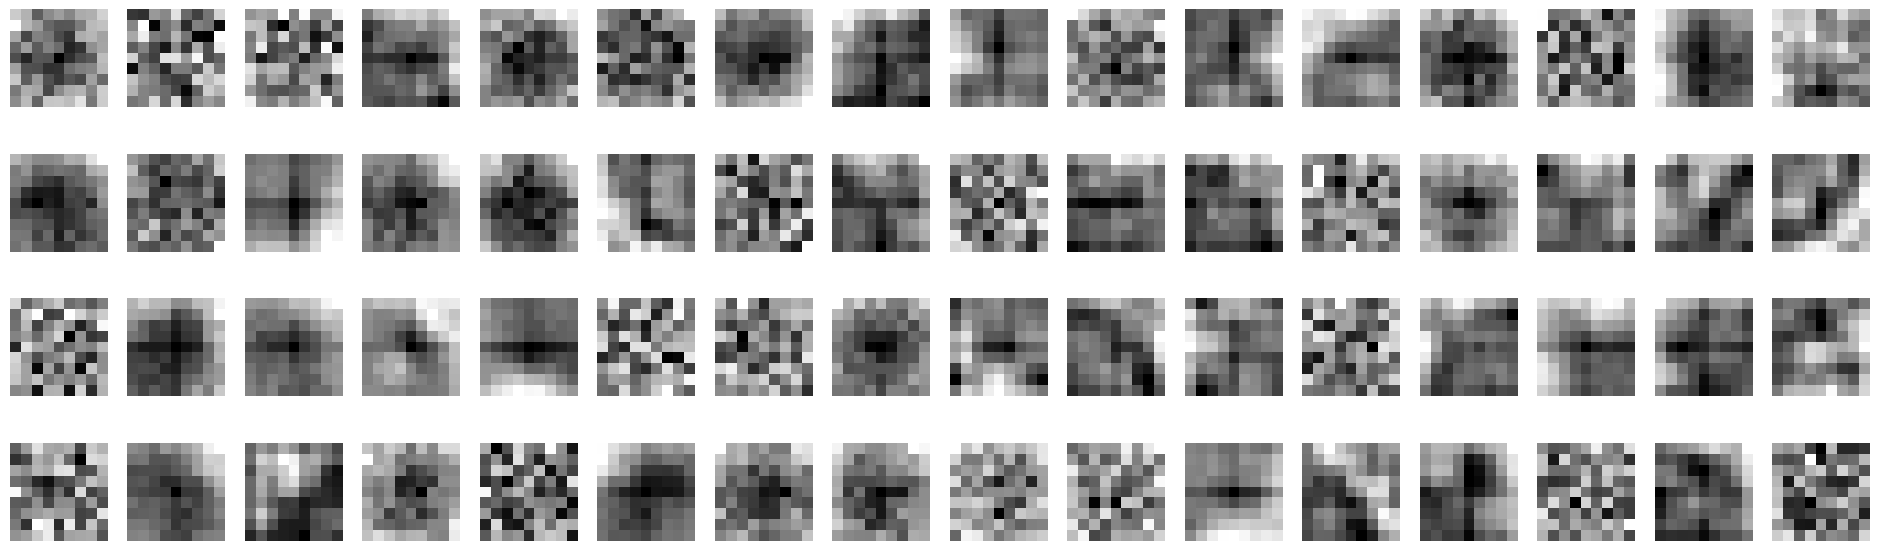

--- Channel 3 ---


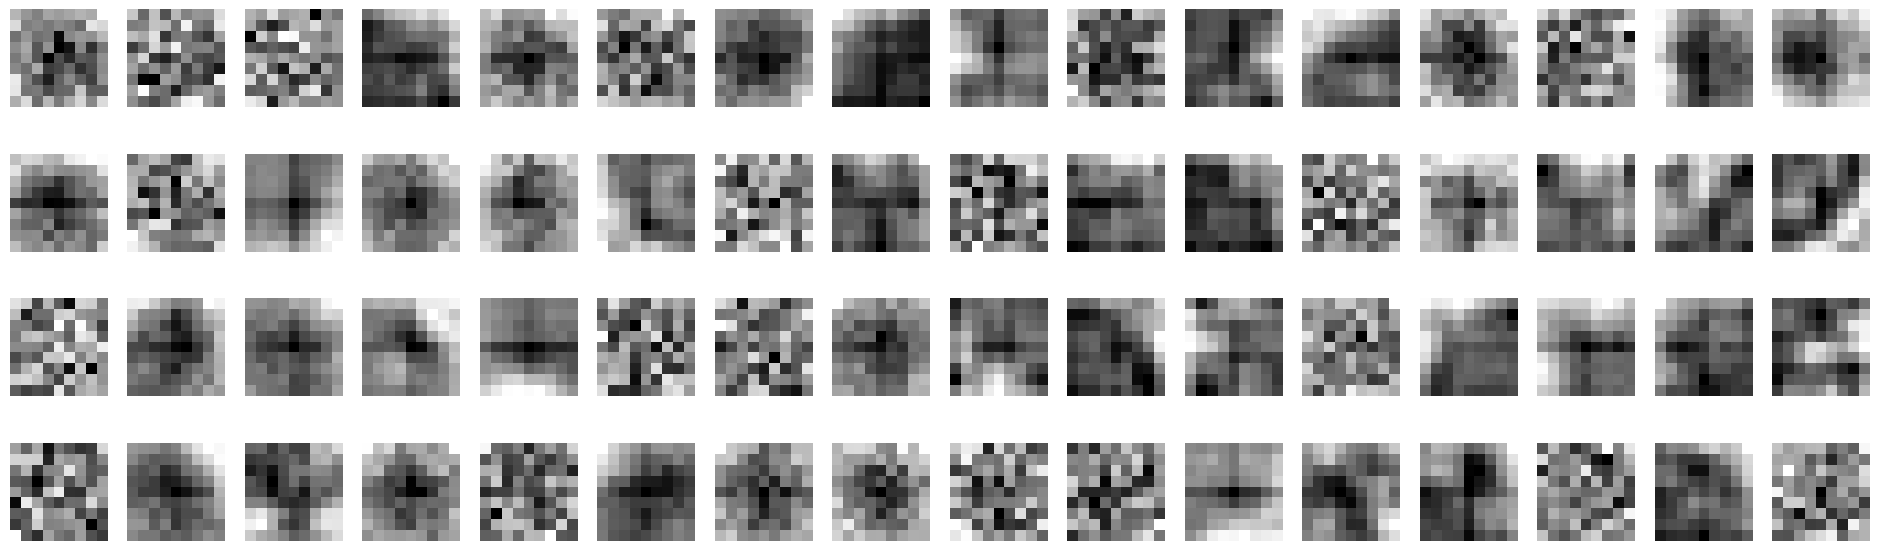

--- Combined RGB ---


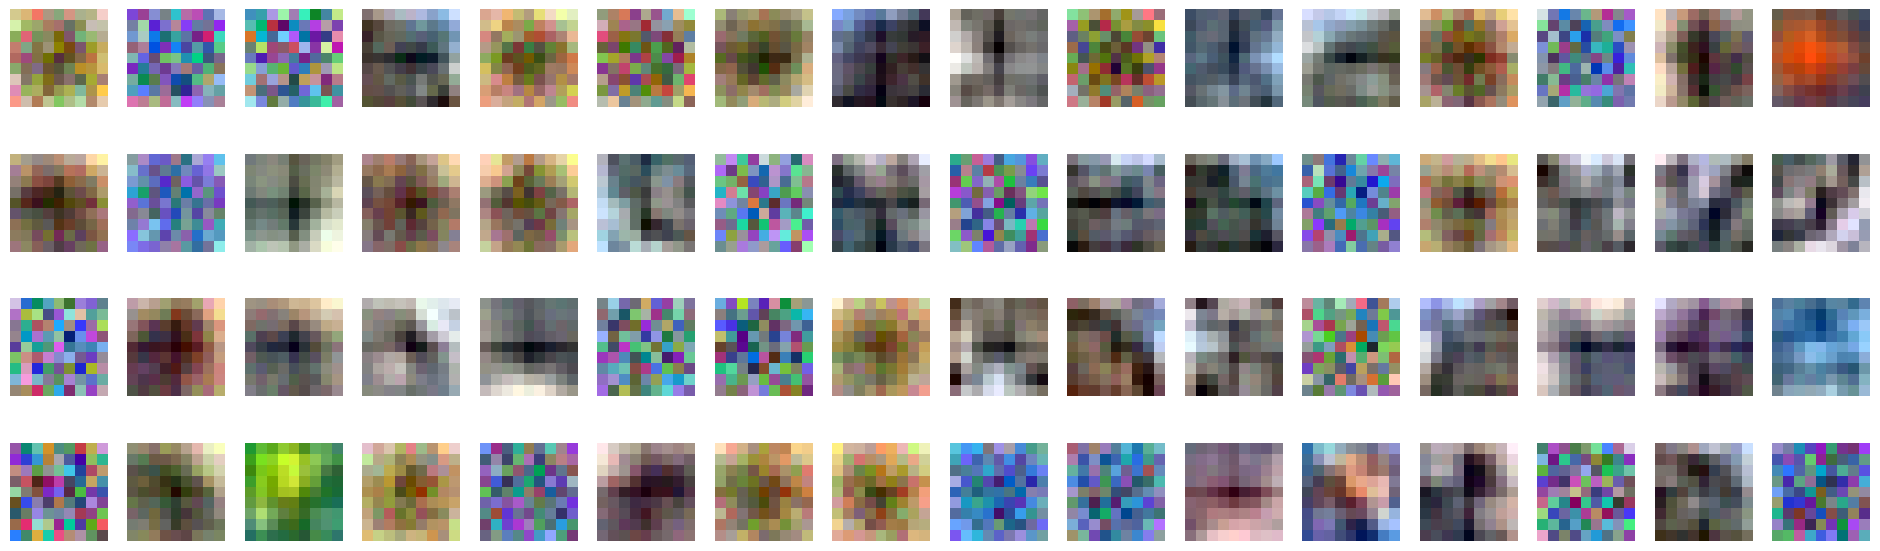

In [77]:
filters_layer_1 = best_cdbn.layer_name_to_object['layer_1'].kernels.eval(session=sess)
plot_subplot(filters_layer_1, combined=True)

#### Filters for Model 2

Model 2 has two convolutional filters so we can see the features captured by the deeper layers

In [93]:
sess = sess_dc2_m2

--- Channel 1 ---


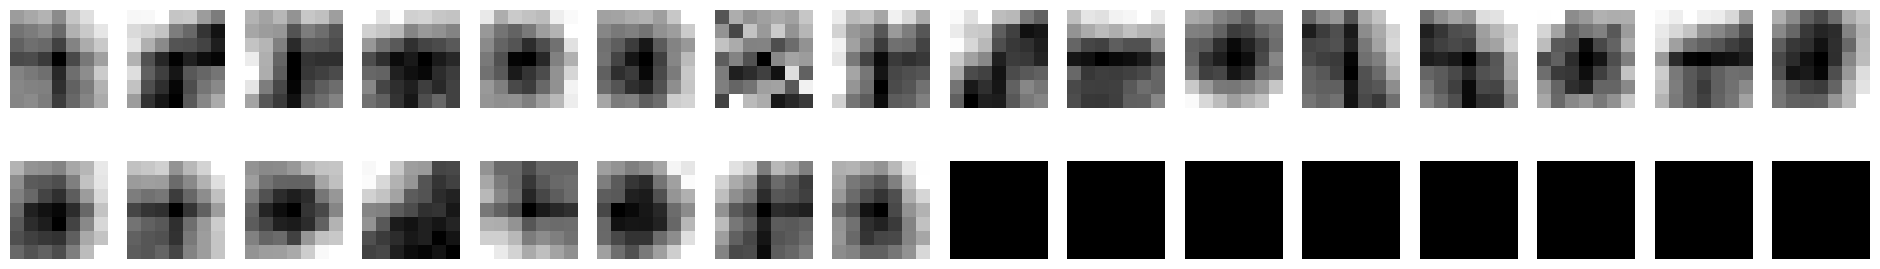

--- Channel 2 ---


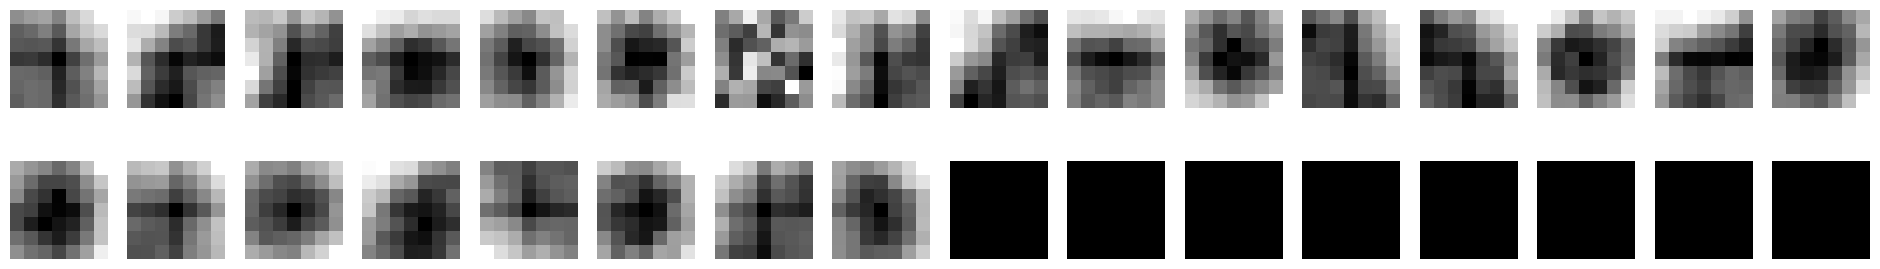

--- Channel 3 ---


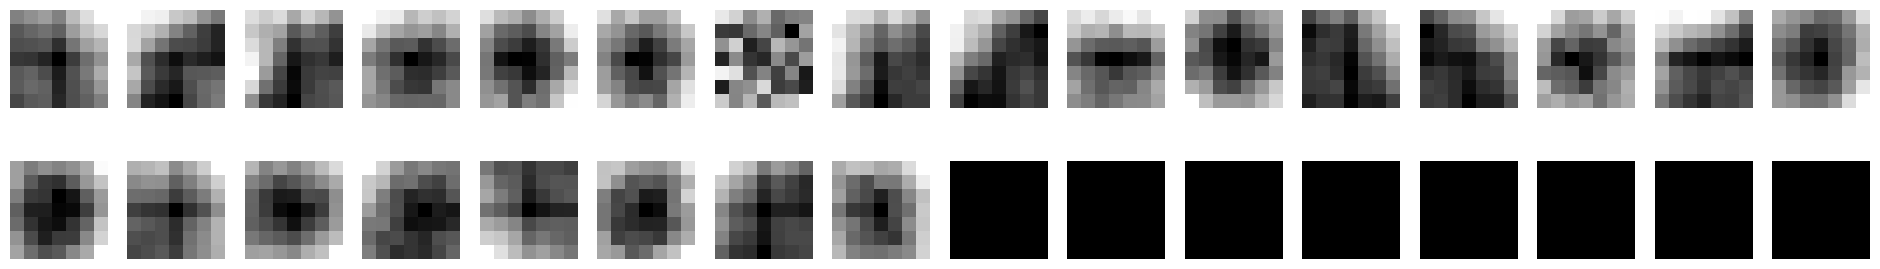

--- Combined RGB ---


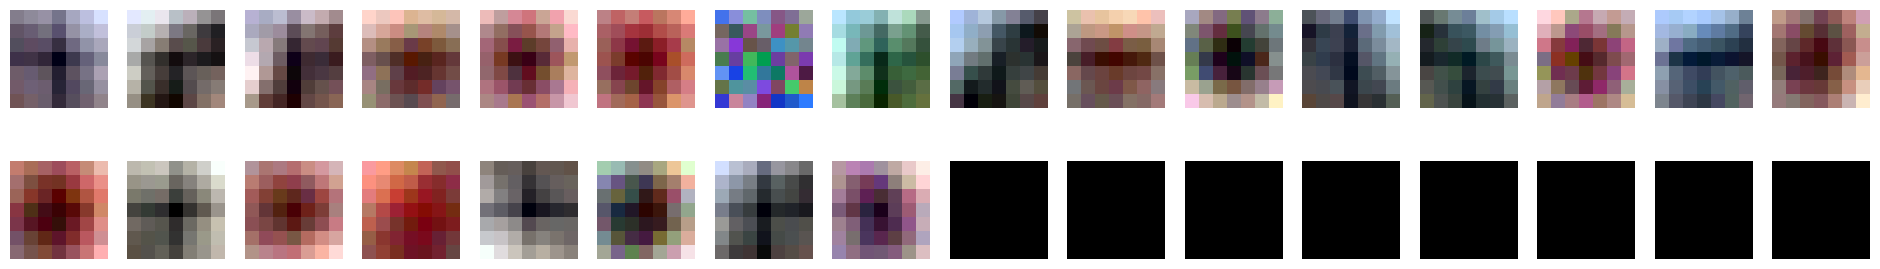

In [94]:
filters_layer_1 = model2.layer_name_to_object['layer_1'].kernels.eval(session=sess)
plot_subplot(filters_layer_1, combined=True)

--- Channel 1 ---


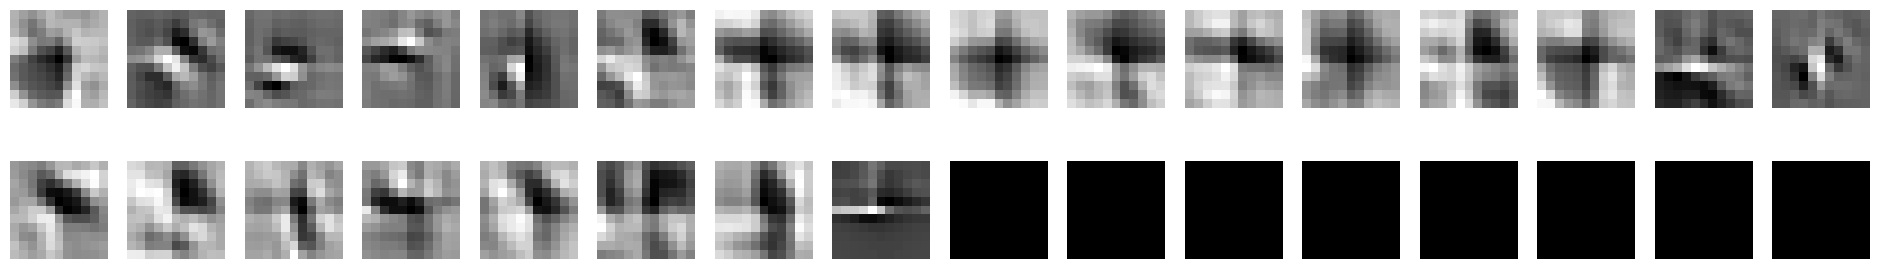

--- Channel 2 ---


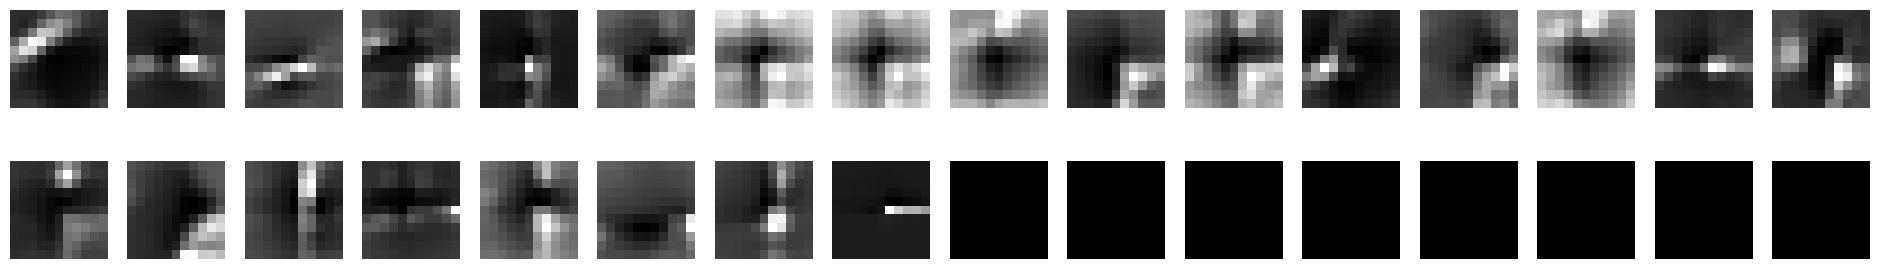

--- Channel 3 ---


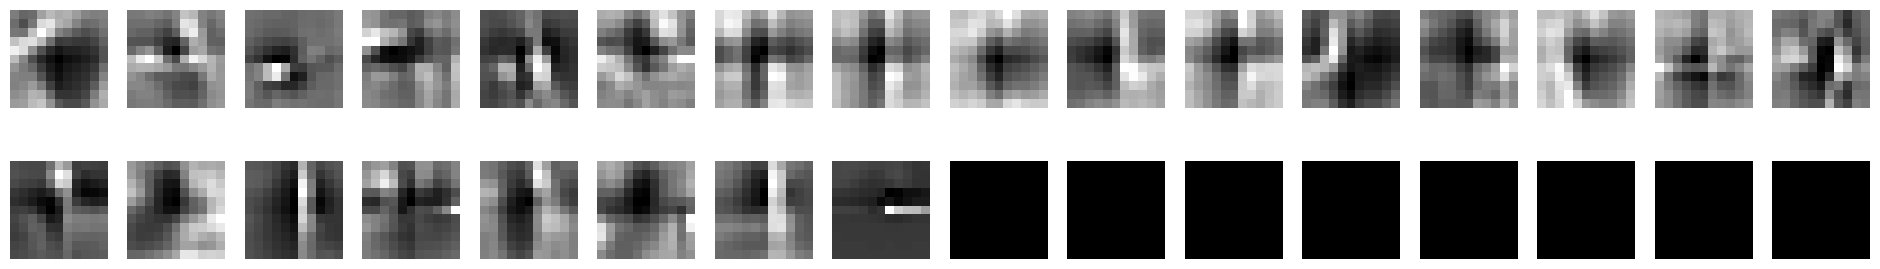

--- Channel 4 ---


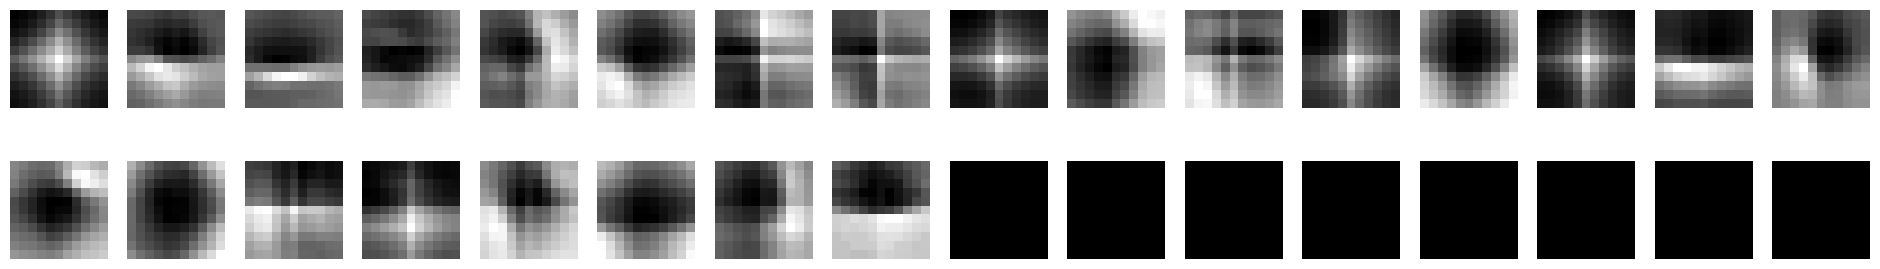

In [95]:
filters_layer_2 = model2.layer_name_to_object['layer_2'].kernels.eval(session=sess)
plot_subplot(filters_layer_2,
             num_channels = 4,
             num_filters = 24)

In [96]:
from scipy.signal import convolve

def get_combination_deeper_filters(this_layer, prv_layer):

        filt_height = prv_layer.shape[0] + this_layer.shape[0] - 1
        filt_width = prv_layer.shape[1] + this_layer.shape[1] - 1

        filt_size = filt_height * filt_width
        all_filters = np.zeros((this_layer.shape[3], filt_size))

        for base_idx in range(this_layer.shape[3]):
            base_filter = np.zeros((filt_height, filt_width))
            for cnl_idx in range(prv_layer.shape[2]):
                reg = 1
                base_filter += convolve(this_layer[:,:,cnl_idx,base_idx]**reg, prv_layer[:,:,cnl_idx,0], 'full')

            all_filters[base_idx, :] = np.reshape(base_filter, filt_size)

        return all_filters

In [102]:
def plot_combined_filters(combination, num_filters):
    num_col = 12
    num_row = math.ceil(num_filters / num_col)

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 1.8 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.set_axis_off()
        if i >= num_filters:
            ax.imshow(np.zeros((combination.shape[0], combination.shape[1], 3)))
        else:
            combined_filter = normalize_filters(combination[:, :, i])
            ax.imshow(combined_filter)
    plt.show()

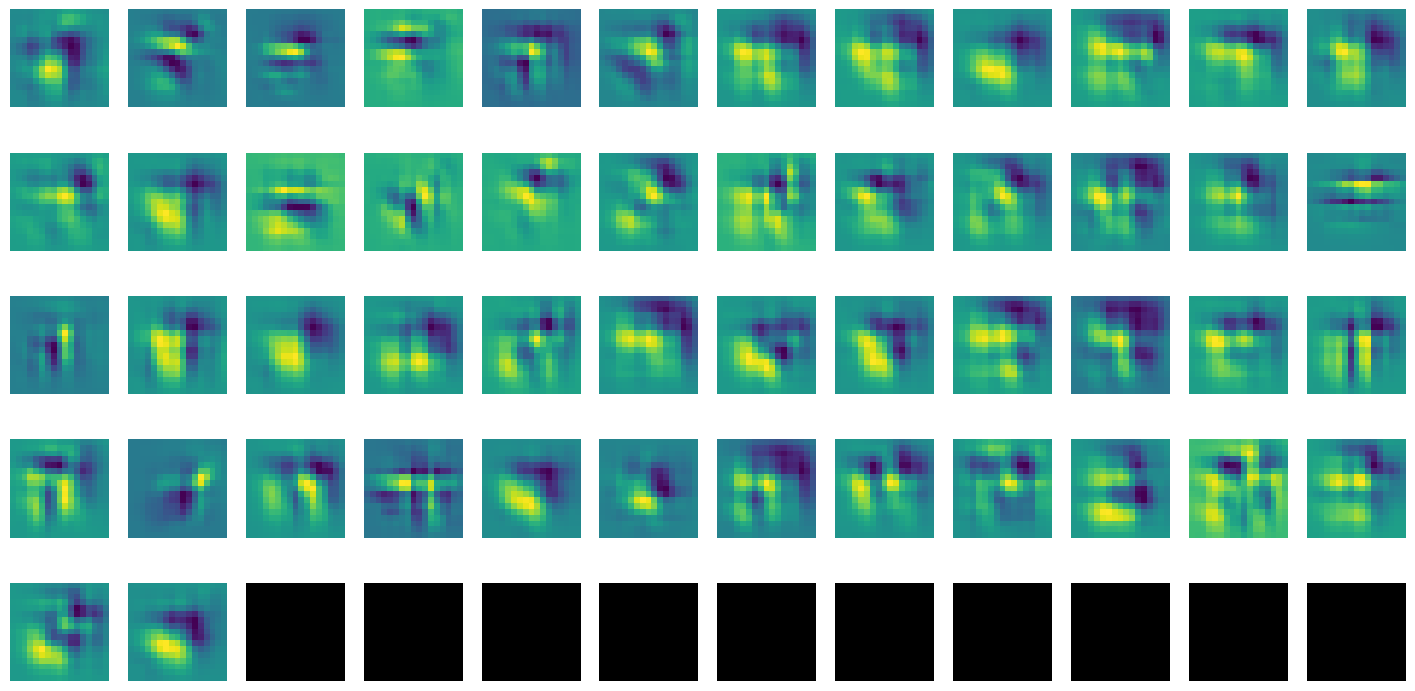

In [104]:
# use the function
combination = get_combination_deeper_filters(filters_layer_2,filters_layer_1)

# some reshaping
combination = combination.swapaxes(0,1)
combination = np.reshape(combination,(np.sqrt(combination.shape[0]).astype('int'),np.sqrt(combination.shape[0]).astype('int'),combination.shape[1]))

#print_images(combination,combination.shape[2])
plot_combined_filters(combination, combination.shape[2])

### Visualizing hidden representations

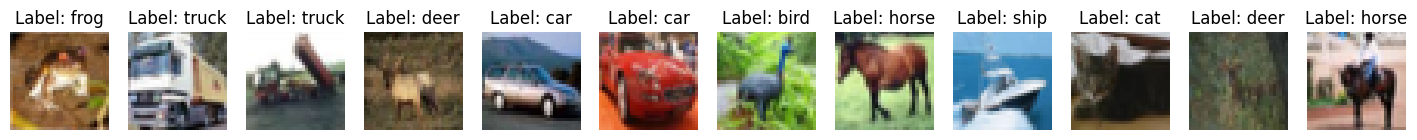

In [98]:
print_images(supervised_training_images,
             num_subplots = 12,
             labels = data_train_labels,
             labels_dict = labels_dict)

In [194]:
def print_imgs(images,num_subplots,labels=None,labels_dict=None,predictions=None):
  num_col = 12
  num_row = math.ceil(num_subplots / num_col)

  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,1.8*num_row),squeeze=False)
  for i in range(num_row * num_col):
      ax = axes[i//num_col, i%num_col]
      ax.set_axis_off()
      if i >= num_subplots: # complete the row with white images if num_subplots is not multiple of num_col
        ax.imshow(np.zeros((images.shape[0],images.shape[0])), cmap='gray_r')
      else:
        if labels is not None and labels_dict is not None and predictions is None:
          ax.set_title("Label: " + labels_dict[labels[i]])
        elif predictions is not None:
          ax.set_title("True: " + labels_dict[labels[i]] + "\nPred: " + labels_dict[predictions[i]])
        ax.imshow(images[:,:,i], cmap='gray')
  plt.show()

In [195]:
def plot_subplt(filters_layer,
                 num_channels = None,
                 num_filters = None,
                 labels = None,
                 labels_dict = None):

  if num_filters is None:
    num_filters = filters_layer.shape[3]
  if num_channels is None:
    num_channels = filters_layer.shape[2]
  for i in range(num_channels):
    print("--- Channel",i+1,"---")
    print_imgs(filters_layer[:,:,i],num_filters,labels,labels_dict)

In [149]:
# Get the input from the bottom to the visible layer of the given level

def get_hidden_rappresentation(data,cdbn,batches,n_layer,sess):

  data = np.reshape(data,(data.shape[0],32,32,3))

  if batch_size * batches > data.shape[0]:
    return -1

  # I make use of a function of the model to get the hidden rappresentation, starting from
  # some input images. As before, since I rely on the internal configuration of the model,
  # I have to repeat this computation in batches of the size of batch_size
  for i in range(batches):
    extracted_data = cdbn._get_input_level(n_layer, data[i*batch_size:(i+1)*batch_size,:,:].astype('float32')).eval(session=sess)
    if i == 0:
      hidden_layer = extracted_data
    else:
      hidden_layer = np.vstack((hidden_layer,extracted_data))
  return hidden_layer

#### Hidden Representations for Model 4
Model 4 only has 1 convolutional layer. So we can only visualize the filters in the first layer as there are no other filters to see.

In [188]:
sess = sess_dc2_m4

In [198]:
first_hidden_layer = get_hidden_rappresentation(supervised_training_images,best_cdbn,50,1, sess)

--- Channel 1 ---


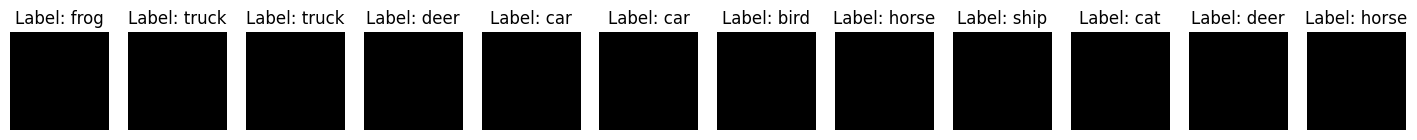

--- Channel 2 ---


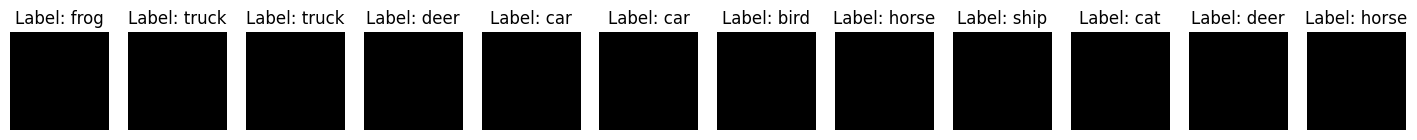

--- Channel 3 ---


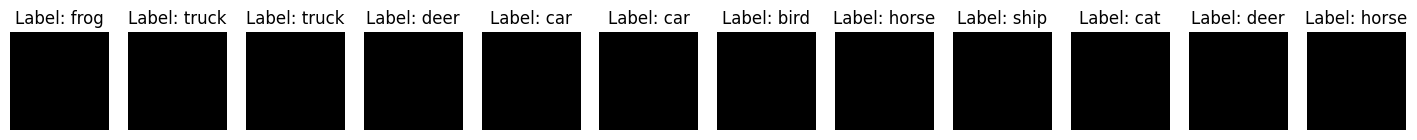

--- Channel 4 ---


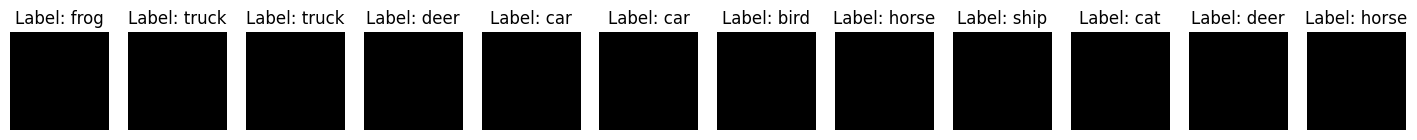

--- Channel 5 ---


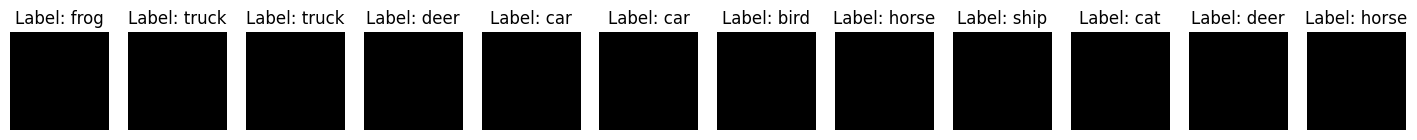

--- Channel 6 ---


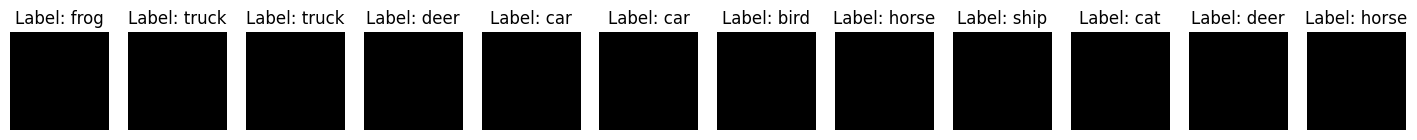

In [196]:
# for each of the first 6 filters, visualize the first 12 activations
plot_subplt(first_hidden_layer.swapaxes(0,1).swapaxes(1,2).swapaxes(2,3),
             num_channels = 6,
             num_filters = 12,
             labels=data_train_labels,
             labels_dict=labels_dict)

#### Hidden Representations for Model 2

Model 2 has two convolutional filters so we can see the representation of the deeper layers

In [167]:
sess = sess_dc2_m2

In [168]:
first_hidden_layer = get_hidden_rappresentation(supervised_training_images,model2,50,1,sess)

--- Channel 1 ---


<ipython-input-92-547d310c2a6f>:22: RuntimeWarning: invalid value encountered in divide
  return (filters - min_val) / (max_val - min_val)


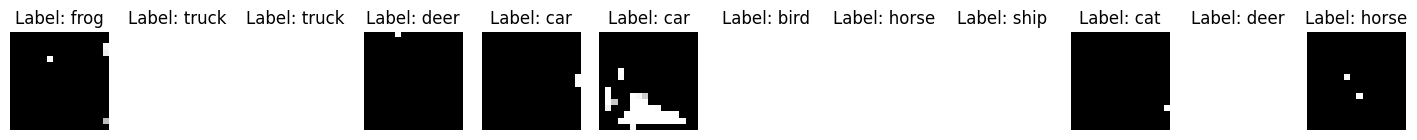

--- Channel 2 ---


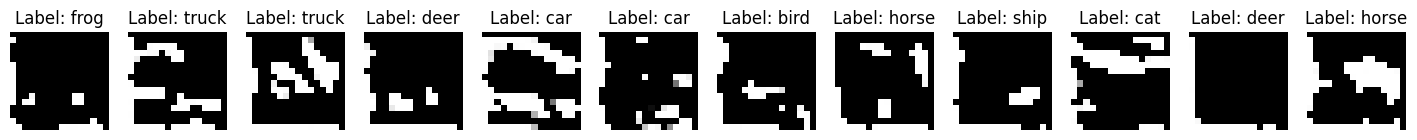

--- Channel 3 ---


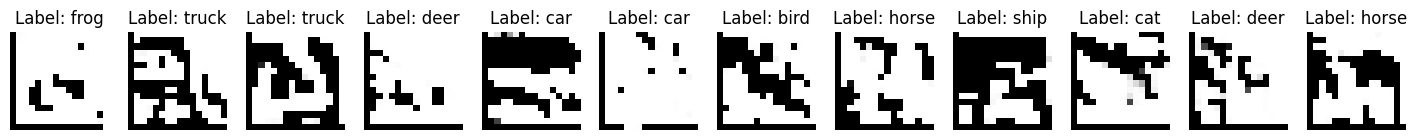

--- Channel 4 ---


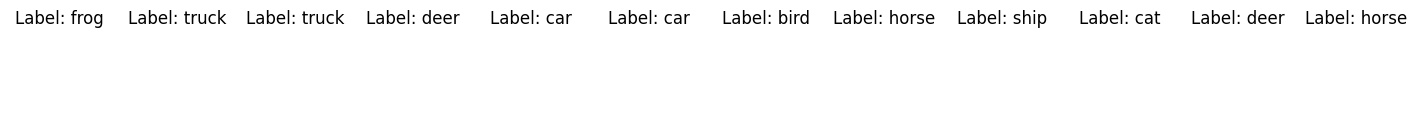

--- Channel 5 ---


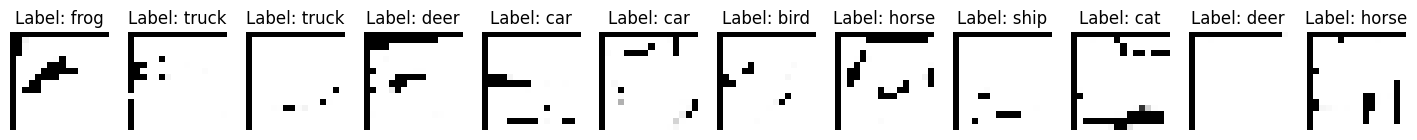

--- Channel 6 ---


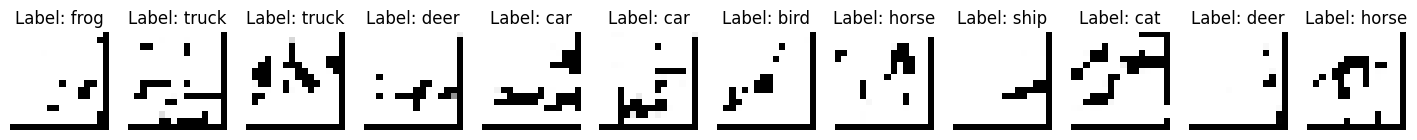

In [169]:
# for each of the first 6 filters, visualize the first 12 activations
plot_subplt(first_hidden_layer.swapaxes(0,1).swapaxes(1,2).swapaxes(2,3),
             num_channels = 6,
             num_filters = 12,
             labels=data_train_labels,
             labels_dict=labels_dict)

In [171]:
second_hidden_layer = get_hidden_rappresentation(supervised_training_images, model2, 50, 2, sess)

--- Channel 1 ---


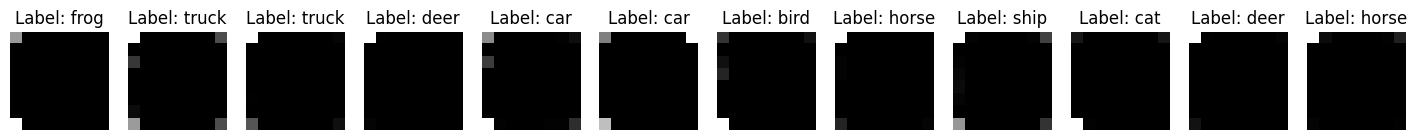

--- Channel 2 ---


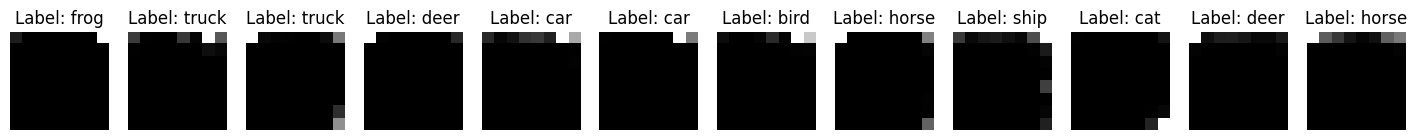

--- Channel 3 ---


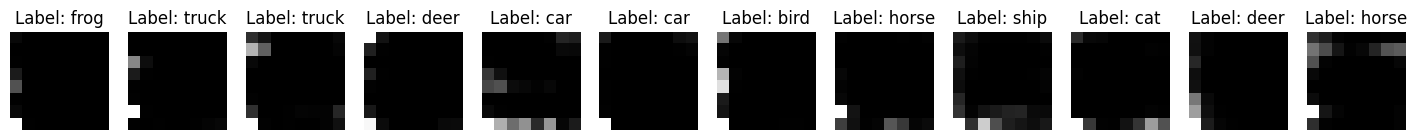

--- Channel 4 ---


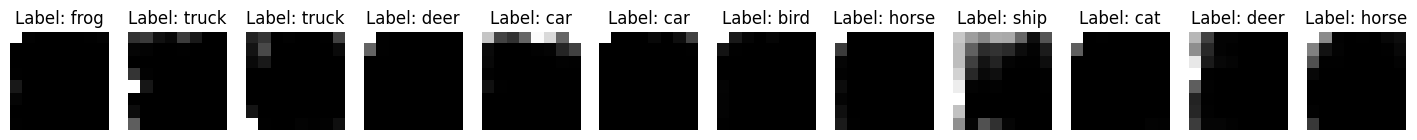

In [174]:
# for each of the first 4 filters, I visualize the first 12 activations
plot_subplt(second_hidden_layer.swapaxes(0,1).swapaxes(1,2).swapaxes(2,3),
             num_channels = 4,
             num_filters = 12,
             labels=data_train_labels,
             labels_dict=labels_dict)

### Visualizing hierarchical representations

In [175]:
# we use this function to filter by class
def _get_mask(label,data):
  return (data == label)

# here we filter by class and compute the mean
def _get_label_to_mean_hidd_repr(hidden_representation,data):
  return {
    label: hidden_representation[_get_mask(label,data)].mean(axis=0)
    for label in range(10)
  }

# we use this to build the matrices
def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [176]:
import scipy.cluster as cluster

def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots(figsize=(20, 12))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage,labels=classes)
  ax.set_title(title)

In [177]:

label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(first_hidden_layer,data_train_labels[:first_hidden_layer.shape[0]])

mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)

# 1.Reshape
mean_hidd_repr_matrix_1_rs = np.reshape(mean_hidd_repr_matrix_1,(mean_hidd_repr_matrix_1.shape[0],mean_hidd_repr_matrix_1.shape[1]**2,mean_hidd_repr_matrix_1.shape[3]))

# 2.Take the "elementwise" mean
mean_hidd_repr_matrix_1_rs_avg = mean_hidd_repr_matrix_1_rs.mean(axis = 2)
mean_hidd_repr_matrix_1_rs_avg.shape

(10, 256)

First Hidden Layer Dendrogram:

1. Structure and Grouping:

The first layer clusters "plane" and "ship" together, indicating they share similar features in this representation.
"Car" and "truck" are grouped, suggesting similarity in their features at this level.
Animal categories like "cat", "dog", "bird", "deer", "frog", and "horse" are more closely linked compared to the vehicle categories.

2. Feature Abstraction:

The features extracted in the first hidden layer are likely more basic and may correspond to simple shapes, edges, or textures. The clear separation between animals and vehicles suggests that the first hidden layer is good at distinguishing broad categories based on low-level features.

3. Cluster Height:

The height of the linkages indicates the distance or dissimilarity between clusters. Higher linkages (such as between "plane" and the rest) suggest significant differences in their feature representations.

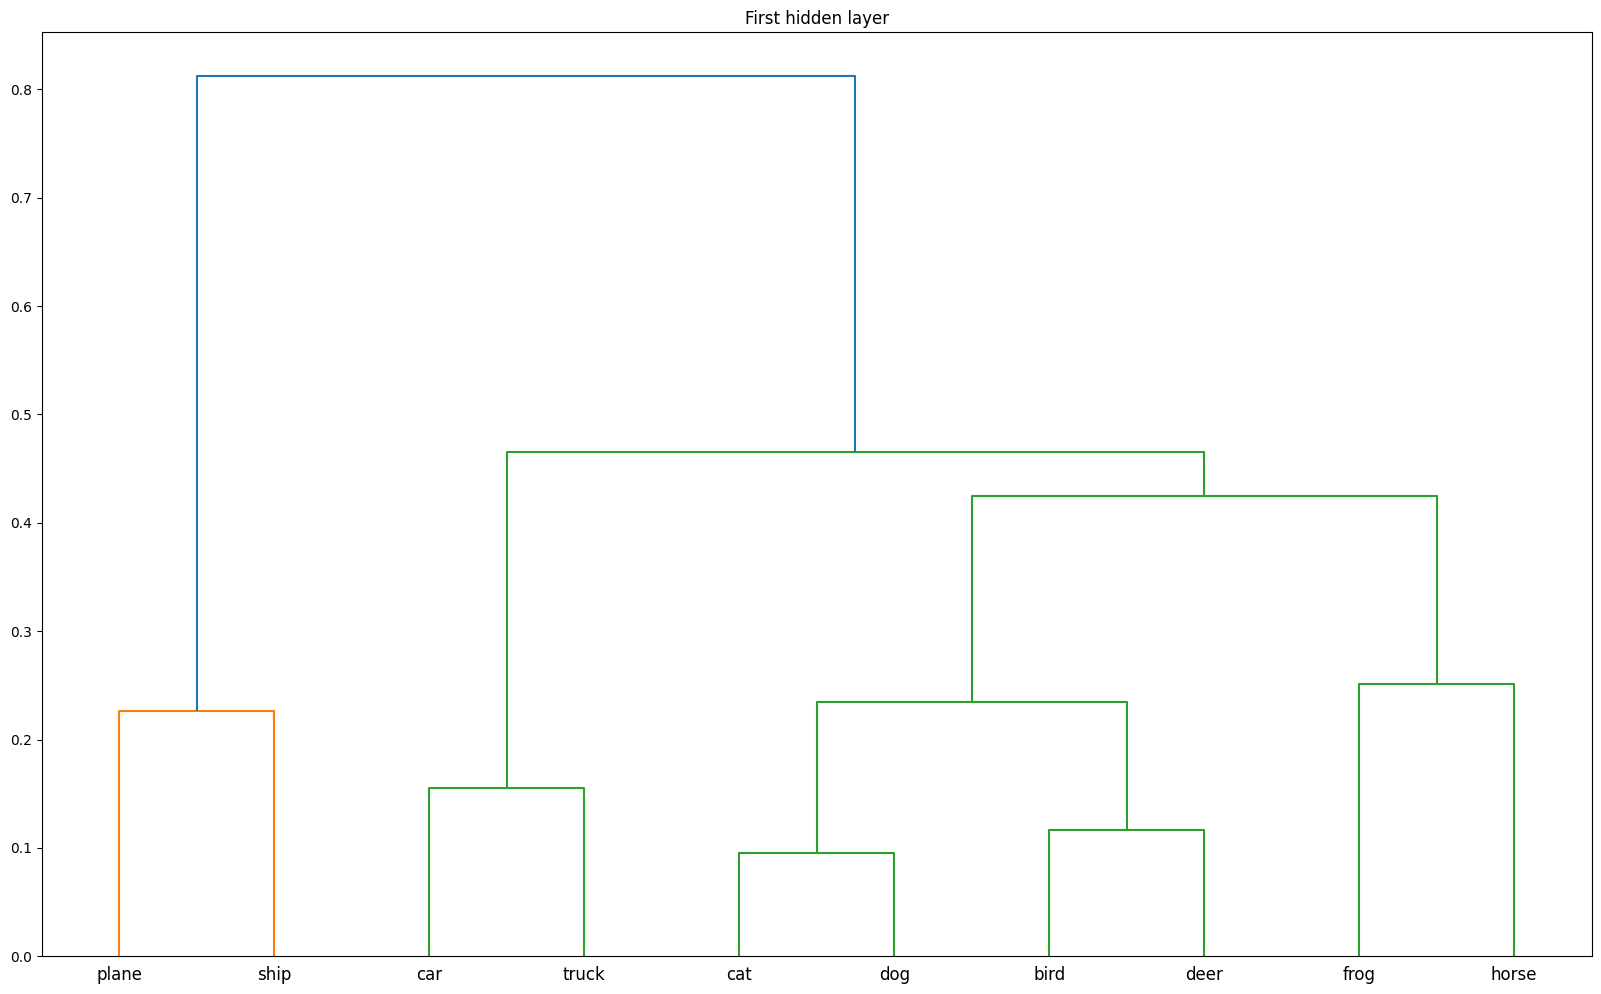

In [178]:
_plot_dendrogram(mean_hidd_repr_matrix_1_rs_avg, "First hidden layer")

In [179]:
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(second_hidden_layer,data_train_labels[:first_hidden_layer.shape[0]])

mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)

# 1.Reshape
mean_hidd_repr_matrix_2_rs = np.reshape(mean_hidd_repr_matrix_2,(mean_hidd_repr_matrix_2.shape[0],mean_hidd_repr_matrix_2.shape[1]**2,mean_hidd_repr_matrix_2.shape[3]))

# 2.Take the "elementwise" mean
mean_hidd_repr_matrix_2_rs_avg = mean_hidd_repr_matrix_2_rs.mean(axis = 2)
mean_hidd_repr_matrix_2_rs_avg.shape

(10, 64)

Second Hidden Layer Dendrogram:

1. Structure and Grouping:

Similar to the first layer, "plane" and "ship" remain clustered together, showing consistent feature similarities through the layers.
The grouping of "car" and "truck" persists, indicating their feature similarities are robust through deeper layers.
There is a notable rearrangement among the animal categories, with "frog" now clustering closer to "cat" and "dog".

2. Feature Abstraction:

The features in the second hidden layer are more abstract and high-level. These features likely capture more complex patterns and combinations of the basic features from the first layer. The rearrangement among animals suggests that higher-level features might capture different aspects, such as specific shapes or postures, rather than just textures or edges.

3. Cluster Height:

The overall height of the linkages has decreased, implying that the second layer representations are more similar to each other than the first layer representations. This decrease in height indicates that the second layer representations are more refined and better at capturing the intrinsic similarities between categories.

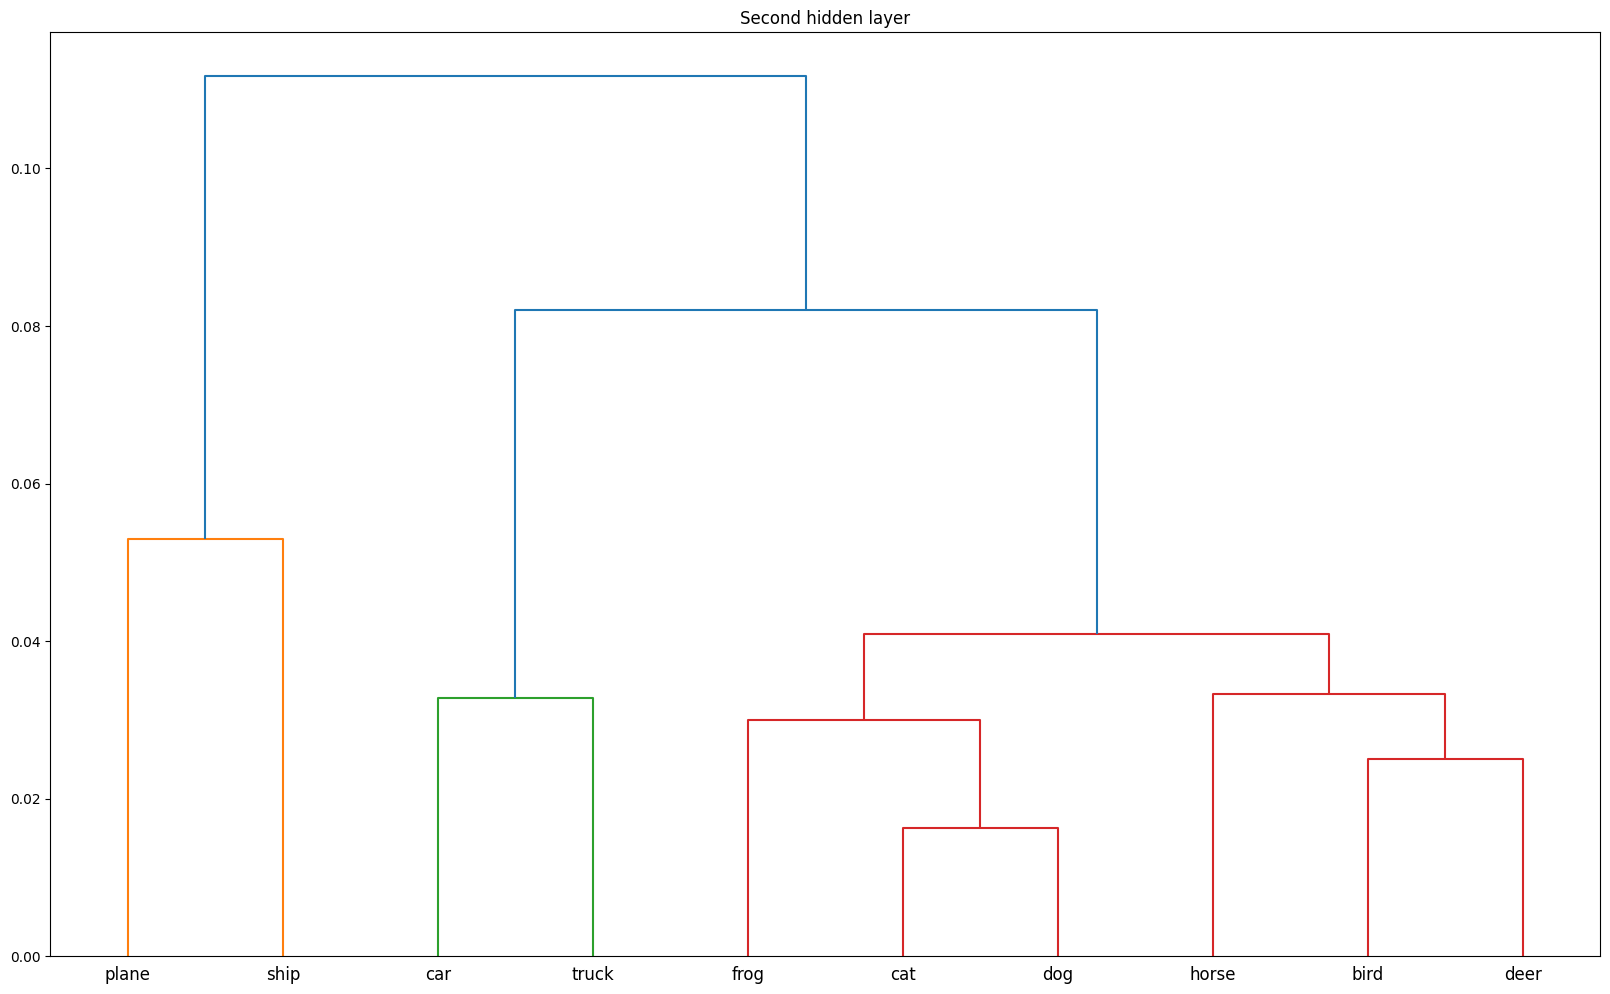

In [180]:
_plot_dendrogram(mean_hidd_repr_matrix_2_rs_avg, "Second hidden layer")

Comparison:

- Consistency in Grouping: The consistent grouping of "plane" and "ship", as well as "car" and "truck", across both layers indicates that these categories share strong feature similarities that are preserved through multiple layers of the RBM.
- Change in Animal Grouping: The shifts in animal category clustering suggest that the second hidden layer captures more nuanced distinctions among animals
- Feature Refinement: The decrease in the height of animal linkages in the second layer dendrogram reflects a refinement in the features, making categories more similar in terms of their high-level representations.

### Performance comparison with Convolutional Neural Network on Noise Robustness

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.python.framework.random_seed import set_random_seed

# this fuction trains the CNN on the training set and evaluates it on
# the test set
def train_evaluate_cnn(
                   supervised_training_images,
                   supervised_training_labels,
                   test_images,
                   test_labels):

  np.random.seed(123)
  set_random_seed(2)

  cnn = Sequential()

  # first convolutional layer
  cnn.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same',
                 activation='relu', input_shape=(32, 32, 3)))
  cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  # second convolutional layer
  cnn.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same',
                 activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2,2)))
  cnn.add(Flatten())

  # fully connected layer
  cnn.add(Dense(units=128, activation='relu'))

  # output layer
  cnn.add(Dense(units=10, activation='softmax'))

  cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history = cnn.fit(supervised_training_images.reshape((supervised_training_images.shape[0],32,32,3)),
                      supervised_training_labels,
                      epochs=10,
                      batch_size=200,
                      verbose=1)


  accuracy_cnn_test = cnn.evaluate(test_images.reshape((test_images.shape[0],32,32,3)),
                           test_labels)[1]

  return accuracy_cnn_test, cnn


In [ ]:
accuracy_cnn_test, cnn = train_evaluate_cnn(supervised_training_images,
                                            supervised_training_labels,
                                            test_images,
                                            test_labels)



Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 331us/sample - loss: 1.5753 - accuracy: 0.4362
Epoch 2/10
50000/50000 [==============================] - 13s 265us/sample - loss: 1.1734 - accuracy: 0.5860
Epoch 3/10
50000/50000 [==============================] - 12s 244us/sample - loss: 1.0203 - accuracy: 0.6426
Epoch 4/10
50000/50000 [==============================] - 14s 276us/sample - loss: 0.9029 - accuracy: 0.6863
Epoch 5/10
50000/50000 [==============================] - 13s 251us/sample - loss: 0.8312 - accuracy: 0.7107
Epoch 6/10
50000/50000 [==============================] - 10s 205us/sample - loss: 0.7557 - accuracy: 0.7369
Epoch 7/10
50000/50000 [==============================] - 14s 274us/sample - loss: 0.6931 - accuracy: 0.7594
Epoch 8/10
50000/50000 [==============================] - 11s 210us/sample - loss: 0.6252 - accuracy: 0.7813
Epoch 9/10
50000/50000 [==============================] - 17s 339us/sample - loss: 0.5662 - accuracy: 0.8

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
print("Accuracy on test set is:",accuracy_cnn_test)

Accuracy on test set is: 0.7044


Clearly the CNN outperforms the CRBM.

CNNs use backpropagation with gradient descent to update weights, which is highly efficient and stable. However, CRBMs rely on contrastive divergence for training, which can be less stable and efficient compared to backpropagation Furthermore, training RBMs involves sampling, which can be computationally expensive.

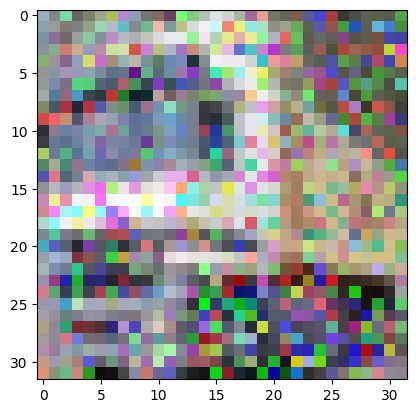

In [ ]:
import torch
import torchvision as tv

# function to inject gaussian noise on a dataset. The noise level
# specifies the amount of noise that is added to each image.

def _inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape)/6.6 + .6
  probability_tensor = torch.ones(data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return data - mask_tensor * data + mask_tensor * random_gaussian_tensor


noise_level = 0.3
cifar_test_with_noise = _inject_noise(torch.tensor(supervised_training_images), noise_level)
__ = plt.imshow(cifar_test_with_noise[1].reshape(32, 32, 3), cmap="gray")



In [ ]:
from sklearn.metrics import accuracy_score

# This function evaluates both models on the same noisy data

def _get_accuracy_values_at_noise_level(noise_level):

  # inject noise in data
  cifar_test_noisy = _inject_noise(torch.tensor(test_images), noise_level).numpy()[:2000]

  # evaluation of CDBN
  predicted_cdbn_noisy = softmax_prediction(cifar_test_noisy,my_cdbn_2c,batches=10)
  accuracy_cdbn = accuracy_score(predicted_cdbn_noisy,data_test_labels[:predicted_cdbn_noisy.shape[0]])

  # evaluation of CNN
  accuracy_cnn = cnn.evaluate(cifar_test_noisy.reshape((cifar_test_noisy.shape[0],32,32,3)),
                           test_labels[:cifar_test_noisy.shape[0]])[1]


  return accuracy_cdbn, accuracy_cnn

In [ ]:
# this function plots the results of the evaluation of both models
# on a grid of noise levels

def plot_noise_robustness_curves(noise_levels):
  accuracy_values_cdbn = []
  accuracy_values_cnn = []

  for noise_level in noise_levels:
    accuracy_cdbn, accuracy_cnn = _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_cdbn.append(accuracy_cdbn)
    accuracy_values_cnn.append(accuracy_cnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_cdbn)
  ax.plot(range(len(noise_levels)), accuracy_values_cnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["CDBN", "CNN"])

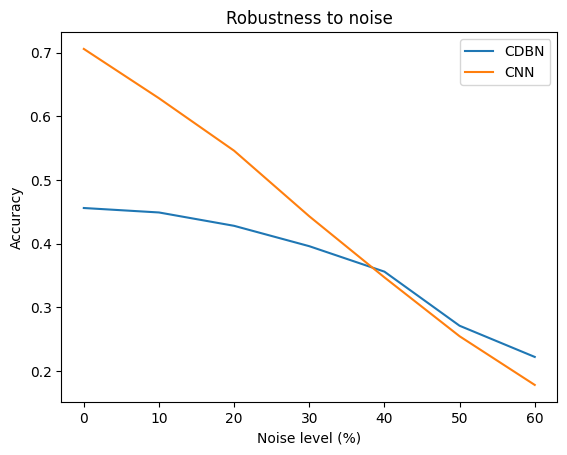

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plot_noise_robustness_curves(noise_levels)

The starting accuracy of the CRBM is much lower than that of the CNN, so their performance is not directly comparable. For a better comparison, we can plot the change in accuracy relative to each model's initial accuracy.

In [ ]:
import matplotlib.pyplot as plt

def plot_relative_noise_robustness_curves(noise_levels):
    accuracy_values_cdbn = []
    accuracy_values_cnn = []

    # Get accuracy values at the initial noise level (assuming first in the list is zero noise level)
    initial_accuracy_cdbn, initial_accuracy_cnn = _get_accuracy_values_at_noise_level(noise_levels[0])

    for noise_level in noise_levels:
        accuracy_cdbn, accuracy_cnn = _get_accuracy_values_at_noise_level(noise_level)
        accuracy_values_cdbn.append(accuracy_cdbn)
        accuracy_values_cnn.append(accuracy_cnn)

    # Calculate relative decrease in accuracy
    relative_decrease_cdbn = [(initial_accuracy_cdbn - acc) / initial_accuracy_cdbn * 100 for acc in accuracy_values_cdbn]
    relative_decrease_cnn = [(initial_accuracy_cnn - acc) / initial_accuracy_cnn * 100 for acc in accuracy_values_cnn]

    fig, ax = plt.subplots()
    ax.plot(range(len(noise_levels)), relative_decrease_cdbn)
    ax.plot(range(len(noise_levels)), relative_decrease_cnn)

    ax.set_title("Relative Decrease in Accuracy with Noise")
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Relative Decrease in Accuracy (%)")
    plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
    plt.legend(["CDBN", "CNN"])
    plt.show()

# Example usage (assuming you have defined _get_accuracy_values_at_noise_level and noise_levels)
# noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# plot_noise_robustness_curves(noise_levels)


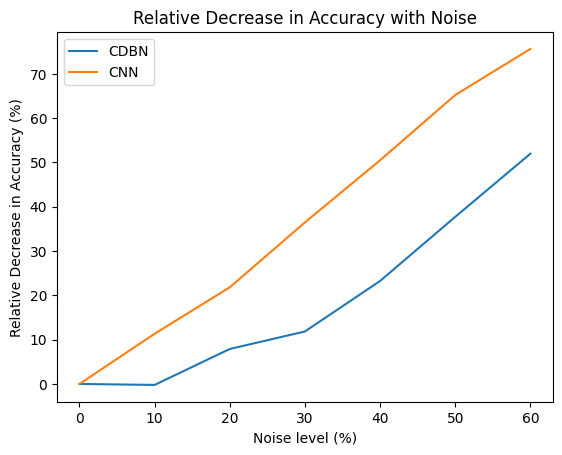

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plot_relative_noise_robustness_curves(noise_levels)

From the Relative Accuracy plot, we can clearly see that the CDBN decreases at a slower rate than the CNN meaning that it is more robust to noise.

CRBMs learn a distributed representation of the data, where each unit (neuron) in the RBM typically represents a feature or a latent variable. This distributed representation tends to be more robust to noise because small changes in input do not drastically alter the overall representation.

On the other hand, CNNs exploit the spatial locality of data through shared weights and local receptive fields. This design makes them sensitive to local variations and noise, as changes in small areas of the input can affect specific feature detectors.